# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Processamento de Linguagem Natural</font>

## Neural Machine Translation

### Inteligência Artificial Para Tradução de Idiomas Implementado com TensorFlow

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.7.6


In [2]:
!nvidia-smi

Sun May 24 17:02:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    On   | 00000000:05:00.0  On |                  N/A |
| 24%   41C    P8    10W / 250W |     94MiB / 12194MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:09:00.0 Off |                  N/A |
| 23%   36C    P8     9W / 250W |      2MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [4]:
# Imports
import os
import csv
import zipfile
import math
import random
import collections
import numpy as np
import tensorflow as tf
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from PIL import Image
from collections import Counter
import matplotlib
import matplotlib.gridspec as gridspec
import word2vec
%matplotlib inline

from nltk.translate.bleu_score import corpus_bleu
import nltk

In [5]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

matplotlib.pylab 1.18.4
PIL.Image        7.0.0
tensorflow       2.2.0
csv              1.0
numpy            1.18.4
matplotlib       3.2.1
nltk             3.4.5
Data Science Academy


In [6]:
# Obs: Este script está compatível com as versões 1.x e 2.x do TensorFlow.
# Optamos por manter assim, pois alguns recursos avançados usados neste script ainda não foram implementados no TF 2.

# Para executar este script com TF 2, nenhum passo adicional precisa ser feito.
# Para executar com TF 1, remova o prefixo tf.compat.v1 ao longo do scriipt e substitua por tf, e comente as 3 linhas abaixo.
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
tf.compat.v1.disable_eager_execution()

## Dataset

Faça o download do dataset nesta [página](https://nlp.stanford.edu/projects/nmt/). Os arquivos necessários são:

* Arquivo contendo as sentenças em alemão: [`train.de`](https://nlp.stanford.edu/projects/nmt/data/wmt14.en-de/train.de)
* Arquivo contendo as sentenças em inglês: [`train.en`](https://nlp.stanford.edu/projects/nmt/data/wmt14.en-de/train.en)
* Arquivo contendo o vocabulário em alemão: [`vocab.50K.de`](https://nlp.stanford.edu/projects/nmt/data/wmt14.en-de/vocab.50K.de)
* Arquivo contendo o vocabulário em inglês: [`vocab.50K.en`](https://nlp.stanford.edu/projects/nmt/data/wmt14.en-de/vocab.50K.en)

### Arquitetura do NMT

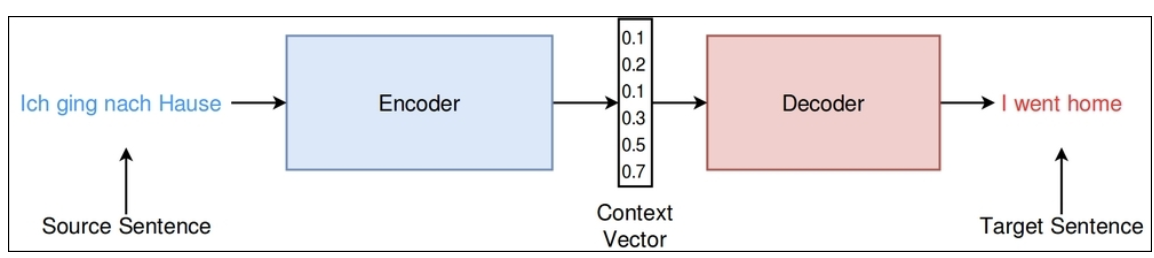

In [7]:
from IPython.display import Image
Image(filename='images/image1.png')

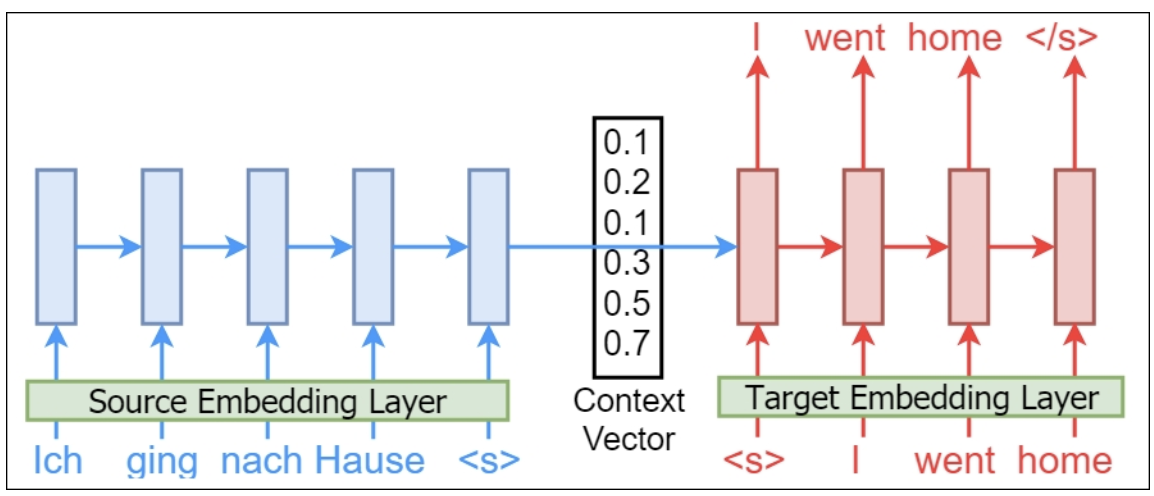

In [8]:
from IPython.display import Image
Image(filename='images/image2.png')

### Carregando os Datasets e Construindo o Vocabulário

Primeiro, construímos os dicionários de vocabulário para os idiomas de origem (alemão) e de destino (inglês). Os vocabulários são encontrados nos arquivos `vocab.50K.de` (Alemão) e `vocab.50K.en` (Inglês).

In [9]:
# Construindo o vocabulário do idioma de origem

# Contém word string -> ID mapping
src_dictionary = dict()

# Lê o arquivo de vocabulário
with open('/media/datasets/PLN/Cap11/data/vocab.50K.de', encoding='utf-8') as f:
    # Lê e armazena todas as linhas
    for line in f:
        # Estamos descartando último char pois é nova linha
        src_dictionary[line[:-1]] = len(src_dictionary)

# Construindo um dicionário reverso com o mapping ID -> word string
src_reverse_dictionary = dict(zip(src_dictionary.values(),src_dictionary.keys()))

# Imprimir algumas das palavras no dicionário
print('Source')
print('\n',list(src_dictionary.items())[:10])
print('\n',list(src_reverse_dictionary.items())[:10])
print('\n','Tamanho do vocabulário: ', len(src_dictionary))


# Construindo o vocabulário do idioma de origem

# Contém word string -> ID mapping
tgt_dictionary = dict()

# Lê o arquivo de vocabulário
with open('/media/datasets/PLN/Cap11/data/vocab.50K.en', encoding='utf-8') as f:
    for line in f:
        tgt_dictionary[line[:-1]] = len(tgt_dictionary)

# Construindo um dicionário reverso com o mapping ID -> word string
tgt_reverse_dictionary = dict(zip(tgt_dictionary.values(),tgt_dictionary.keys()))

# Imprimir algumas das palavras no dicionário
print('\nTarget')
print('\n',list(tgt_dictionary.items())[:10])
print('\n',list(tgt_reverse_dictionary.items())[:10])
print('\n','Tamanho do vocabulário: ', len(tgt_dictionary))

# Cada idioma tem 50000 palavras
vocabulary_size = 50000

Source

 [('<unk>', 0), ('<s>', 1), ('</s>', 2), (',', 3), ('.', 4), ('die', 5), ('der', 6), ('und', 7), ('in', 8), ('zu', 9)]

 [(0, '<unk>'), (1, '<s>'), (2, '</s>'), (3, ','), (4, '.'), (5, 'die'), (6, 'der'), (7, 'und'), (8, 'in'), (9, 'zu')]

 Tamanho do vocabulário:  50000

Target

 [('<unk>', 0), ('<s>', 1), ('</s>', 2), ('the', 3), (',', 4), ('.', 5), ('of', 6), ('and', 7), ('to', 8), ('in', 9)]

 [(0, '<unk>'), (1, '<s>'), (2, '</s>'), (3, 'the'), (4, ','), (5, '.'), (6, 'of'), (7, 'and'), (8, 'to'), (9, 'in')]

 Tamanho do vocabulário:  50000


### Carregando Milhões de Registros - Dados de Treinamento e Teste

Aqui nós carregamos os dados nos arquivos `newstest2012.de.txt` e `newstest2012.en.txt` e dividimos os dados nos arquivos em dois conjuntos: treinamento e teste.

In [10]:
# Contém as sentenças de treinamento
source_sent = [] # Input
target_sent = [] # Output

# Contém as sentenças de teste
test_source_sent = [] # Input
test_target_sent = [] # Output

# Nós pegamos cerca de 100 linhas de dados que são intercalados nas primeiras 50000 frases
test_indices = [l_i for l_i in range(50,50001,500)]

# Lê o arquivo de dados de origem e lê as primeiras 250.000 linhas (exceto as primeiras 50)
with open('/media/datasets/PLN/Cap11/data/train.de', encoding='utf-8') as f:
    for l_i, line in enumerate(f):
        # Descartando as primeiras 50 traduções, pois havia alguns mapeamentos de inglês para inglês
        # encontrados nas primeiras linhas, que estão erradas.
        if l_i < 50:
            continue

        if len(source_sent) < 250000 and l_i not in test_indices:
            source_sent.append(line)
        elif l_i in test_indices:
            test_source_sent.append(line)

# Lê o arquivo de dados de destino e lê as primeiras 250.000 linhas (exceto as primeiras 50)
with open('/media/datasets/PLN/Cap11/data/train.en', encoding='utf-8') as f:
    for l_i, line in enumerate(f):
        # Descartando as primeiras 50 traduções, pois havia alguns mapeamentos de inglês para inglês
        # encontrados nas primeiras linhas, que estão erradas.
        if l_i < 50:
            continue

        if len(target_sent) < 250000 and l_i not in test_indices:
            target_sent.append(line)
        elif l_i in test_indices:
            test_target_sent.append(line)

# Certifique-se de extrair o mesmo número de sentenças de origem e de destino
assert len(source_sent)==len(target_sent),'Source: %d, Target: %d'%(len(source_sent),len(target_sent))

# Imprimir algumas frases de origem
print('Exemplos de traduções (%d)'%len(source_sent))
for i in range(0,250000,10000):
    print('(',i,') DE: ', source_sent[i])
    print('(',i,') EN: ', target_sent[i])

# Imprimir algumas frases de destino
print('Exemplos de traduções de teste (%d)'%len(test_source_sent))
for i in range(0,100,10):
    print('DE: ', test_source_sent[i])
    print('EN: ', test_target_sent[i])

Exemplos de traduções (250000)
( 0 ) DE:  Hier erfahren Sie , wie Sie Creative Suite 2 und Creative Suite 3 am besten zusammen mit QuarkXPress nutzen können .

( 0 ) EN:  Here , you ’ ll find out how Creative Suite users can get the best possible interaction with QuarkXPress .

( 10000 ) DE:  Für die sehr günstigen Wochen- und Monatskarten ( 1 Monat ca.

( 10000 ) EN:  It is THE trendy area of Marseille .

( 20000 ) DE:  Freuen Sie sich auf die romantische Atmosphäre in den Zimmern und Apartments .

( 20000 ) EN:  Enjoy the romantic atmosphere of one of the guest rooms or apartments .

( 30000 ) DE:  Zu zwiespältig sind Dr. Gutherzens Erfahrungen aus frühen Studententagen verlaufen , in denen er sich in die Gefielde von durch Heidegger geprägten Autor / innen begeben hat und dort ständig mit strengem Blick darauf verwiesen wurde , er habe bestimmte Theorieressourcen und Gedankengebäude einfach noch nicht gründlich genug verstanden und könne deshalb nicht begreifen , warum seine Einwänd

### Pré-Processamento do Texto

Aqui nós pré-processamos o texto, substituindo palavras não encontradas no dicionário com `<unk>`, bem como removemos sinais de pontuação ( `.`,`, `) e nova linha de caracteres.

In [11]:
# Acompanhamos quantas palavras desconhecidas foram encontradas
src_unk_count, tgt_unk_count = 0, 0

def split_to_tokens(sent,is_source):
    # Essa função recebe uma frase (origem ou destino) e pré-processa a sentença com várias etapas
    # (por exemplo, remover pontuação)

    global src_unk_count, tgt_unk_count

    # Remover pontuação e caracteres de nova linha
    sent = sent.replace(',',' ,')
    sent = sent.replace('.',' .')
    sent = sent.replace('\n',' ')

    sent_toks = sent.split(' ')

    for t_i, tok in enumerate(sent_toks):
        if is_source:
            # src_dictionary contém word -> word ID mapping para vocabulário de origem
            if tok not in src_dictionary.keys():
                if not len(tok.strip())==0:
                    sent_toks[t_i] = '<unk>'
                    src_unk_count += 1
        else:
            # tgt_dictionary contém word -> word ID mapping para vocabulário de destino
            if tok not in tgt_dictionary.keys():
                if not len(tok.strip())==0:
                    sent_toks[t_i] = '<unk>'
                    tgt_unk_count += 1
    return sent_toks

# Vamos olhar algumas estatísticas das sentenças de origem
# Train - source data
source_len = []
source_mean, source_std = 0,0
for sent in source_sent:
    source_len.append(len(split_to_tokens(sent,True)))

print('(Source) Comprimento Médio de Frase: ', np.mean(source_len))
print('(Source) Desvio Padrão do Comprimento da Frase: ', np.std(source_len))

# Vamos olhar algumas estatísticas das sentenças de destino
# Train - target data
target_len = []
for sent in target_sent:
    target_len.append(len(split_to_tokens(sent,False)))

print('(Target) Comprimento Médio de Frase: ', np.mean(target_len))
print('(Target) Desvio Padrão do Comprimento da Frase: ', np.std(target_len))

# Vamos olhar algumas estatísticas das sentenças de teste (origem)
# Test - source data
test_source_len = []
for sent in test_source_sent:
    test_source_len.append(len(split_to_tokens(sent, True)))

print('(Test-Source) Comprimento Médio de Frase: ', np.mean(test_source_len))
print('(Test-Source) Desvio Padrão do Comprimento da Frase: ', np.std(test_source_len))

# Vamos olhar algumas estatísticas das sentenças de teste (destino)
# Test - target data
test_target_len = []
test_tgt_mean, test_tgt_std = 0,0
for sent in test_target_sent:
    test_target_len.append(len(split_to_tokens(sent, False)))

print('(Test-Target) Comprimento Médio de Frase: ', np.mean(test_target_len))
print('(Test-Target) Desvio Padrão do Comprimento da Frase: ', np.std(test_target_len))

(Source) Comprimento Médio de Frase:  26.244692
(Source) Desvio Padrão do Comprimento da Frase:  13.854376414156501
(Target) Comprimento Médio de Frase:  28.275308
(Target) Desvio Padrão do Comprimento da Frase:  14.925498769057468
(Test-Source) Comprimento Médio de Frase:  26.61
(Test-Source) Desvio Padrão do Comprimento da Frase:  14.800604717375572
(Test-Target) Comprimento Médio de Frase:  29.08
(Test-Target) Desvio Padrão do Comprimento da Frase:  16.19424589167399


### Transformando Sentenças de Treino e de Teste em Comprimento Fixo

Aqui, obtemos todas as sentenças de origem e as sentenças de destino com um tamanho fixo, para que possamos processar as sentenças como lotes.

In [12]:
# Processando dados de treinamento

src_unk_count, tgt_unk_count = 0, 0

train_inputs = []
train_outputs = []

# Escolhido com base nas estatísticas encontradas anteriormente
src_max_sent_length = 41
tgt_max_sent_length = 61

print('Processando Dados de Treinamento ...\n')
for s_i, (src_sent, tgt_sent) in enumerate(zip(source_sent,target_sent)):

    # Quebra as sentenças de origem e de destino nas listas de palavras
    src_sent_tokens = split_to_tokens(src_sent,True)
    tgt_sent_tokens = split_to_tokens(tgt_sent,False)

    # Anexe o ID do token <a> ao início da sentença de origem
    num_src_sent = [src_dictionary['<s>']]

    # Adicione o restante dos IDs das palavras encontradas na sentença de origem
    for tok in src_sent_tokens:
        if tok in src_dictionary.keys():
            num_src_sent.append(src_dictionary[tok])

    # Se o comprimento da sentença de origem estiver abaixo do comprimento máximo permitido anexamos </s> ID do token ao final
    if len(num_src_sent)<src_max_sent_length:
        num_src_sent.extend([src_dictionary['</s>'] for _ in range(src_max_sent_length - len(num_src_sent))])

    # Se o comprimento exceder o comprimento máximo permitido, trunque a sentença
    elif len(num_src_sent)>src_max_sent_length:
        num_src_sent = num_src_sent[:src_max_sent_length]

    # Certifique-se de que a sentença é de comprimento src_max_sent_length
    assert len(num_src_sent)==src_max_sent_length,len(num_src_sent)

    train_inputs.append(num_src_sent)

    # Cria a sentença de destino numérico com IDs de palavra anexados <s> ao início e
    # acrescentamos palavras reais mais tarde
    num_tgt_sent = [tgt_dictionary['<s>']]
    for tok in tgt_sent_tokens:
        if tok in tgt_dictionary.keys():
            num_tgt_sent.append(tgt_dictionary[tok])

    # Modificando as saídas de modo que todas as saídas tenham elementos max_length
    if len(num_tgt_sent)<tgt_max_sent_length:
        num_tgt_sent.extend([tgt_dictionary['</s>'] for _ in range(tgt_max_sent_length - len(num_tgt_sent))])
    elif len(num_tgt_sent)>tgt_max_sent_length:
        num_tgt_sent = num_tgt_sent[:tgt_max_sent_length]

    train_outputs.append(num_tgt_sent)

print('Unk counts Src: %d, Tgt: %d'%(src_unk_count, tgt_unk_count))
print('Sentenças ',len(train_inputs))

assert len(train_inputs)  == len(source_sent),\
        'Tamanho Total dos Elementos: %d, Total de Sentenças: %d'\
                %(len(train_inputs),len(source_sent))

# Fazendo entradas e saídas matrizes NumPy
train_inputs = np.array(train_inputs, dtype=np.int32)
train_outputs = np.array(train_outputs, dtype=np.int32)

# Certifique-se de que o número de entradas e saídas divisíveis por 100
train_inputs = train_inputs[:(train_inputs.shape[0]//100)*100,:]
train_outputs = train_outputs[:(train_outputs.shape[0]//100)*100,:]
print('\nFinalizado o processamento dos dados de treinamento \n')

# Imprimindo alguns dados
print('Amostras de dados de treinamento')
for ti in range(10):
    print('\t',[src_reverse_dictionary[w]  for w in train_inputs[ti,:].tolist()])
    print('\t',[tgt_reverse_dictionary[w]  for w in train_outputs[ti,:].tolist()])
print()
print('\nSentenças ',train_inputs.shape[0])

Processando Dados de Treinamento ...

Unk counts Src: 464223, Tgt: 214783
Sentenças  250000

Finalizado o processamento dos dados de treinamento 

Amostras de dados de treinamento
	 ['<s>', 'Hier', 'erfahren', 'Sie', ',', 'wie', 'Sie', 'Creative', 'Suite', '2', 'und', 'Creative', 'Suite', '3', 'am', 'besten', 'zusammen', 'mit', 'QuarkXPress', 'nutzen', 'können', '.', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>']
	 ['<s>', 'Here', ',', 'you', '’', 'll', 'find', 'out', 'how', 'Creative', 'Suite', 'users', 'can', 'get', 'the', 'best', 'possible', 'interaction', 'with', 'QuarkXPress', '.', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>

In [13]:
# Processando dados de teste

src_unk_count, tgt_unk_count = 0, 0
print('Processando dados de teste ....\n')
test_inputs = []
test_outputs = []
for s_i, (src_sent,tgt_sent) in enumerate(zip(test_source_sent,test_target_sent)):
    src_sent_tokens = split_to_tokens(src_sent,True)
    tgt_sent_tokens = split_to_tokens(tgt_sent,False)

    num_src_sent = [src_dictionary['<s>']]
    for tok in src_sent_tokens:
        if tok in src_dictionary.keys():
            num_src_sent.append(src_dictionary[tok])

    num_tgt_sent = [src_dictionary['<s>']]
    for tok in tgt_sent_tokens:
        if tok in tgt_dictionary.keys():
            num_tgt_sent.append(tgt_dictionary[tok])

    if len(num_src_sent)<src_max_sent_length:
        num_src_sent.extend([src_dictionary['</s>'] for _ in range(src_max_sent_length - len(num_src_sent))])
    elif len(num_src_sent)>src_max_sent_length:
        num_src_sent = num_src_sent[:src_max_sent_length]

    assert len(num_src_sent)==src_max_sent_length, len(num_src_sent)

    test_inputs.append(num_src_sent)

    if len(num_tgt_sent)<tgt_max_sent_length:
        num_tgt_sent.extend([tgt_dictionary['</s>'] for _ in range(tgt_max_sent_length - len(num_tgt_sent))])
    elif len(num_tgt_sent)>tgt_max_sent_length:
        num_tgt_sent = num_tgt_sent[:tgt_max_sent_length]

    assert len(num_tgt_sent)==tgt_max_sent_length, len(num_tgt_sent)

    test_outputs.append(num_tgt_sent)

# Imprimindo alguns dados
print('Unk counts Tgt: %d, Tgt: %d'%(src_unk_count, tgt_unk_count))
print('Finalizado o processamento dos dados de teste ....\n')
test_inputs = np.array(test_inputs,dtype=np.int32)
test_outputs = np.array(test_outputs,dtype=np.int32)
print('Amostras de dados de teste')
for ti in range(10):
    print('\n',[src_reverse_dictionary[w]  for w in test_inputs[ti,:].tolist()])
    print('\n',[tgt_reverse_dictionary[w]  for w in test_outputs[ti,:].tolist()])

Processando dados de teste ....

Unk counts Tgt: 212, Tgt: 107
Finalizado o processamento dos dados de teste ....

Amostras de dados de teste

 ['<s>', 'Heute', 'verstehen', 'sich', 'QuarkXPress', '®', '8', ',', 'Photoshop', '®', 'und', 'Illustrator', '®', 'besser', 'als', 'jemals', 'zuvor', '.', 'Dank', 'HTML', 'und', 'CSS', '\xad', 'können', 'Anwender', 'von', 'QuarkXPress', 'inzwischen', 'alle', 'Medien', 'bedienen', ',', 'und', 'das', 'unabhängig', 'von', 'Anwendungen', 'der', 'Adobe', '®', 'Creative']

 ['<s>', 'Today', ',', 'QuarkXPress', '®', '8', 'has', 'tighter', 'integration', 'with', 'Photoshop', '®', 'and', 'Illustrator', '®', 'than', 'ever', 'before', ',', 'and', 'through', 'standards', 'like', 'HTML', 'and', 'CSS', ',', 'QuarkXPress', 'users', 'can', 'publish', 'across', 'media', 'both', 'independently', 'and', 'alongside', 'Adobe', '®', 'Creative', 'Suite', '®', 'applications', 'like', 'Adobe', 'Flash', '®', '(', 'SWF', ')', 'and', 'Adobe', 'Dreamweaver', '®', '.', '</s>

## Aprendendo as Word Embeddings

Nesta seção, aprendemos as word embeddings para os dois idiomas usando as sentenças que temos. Depois de aprender as word embeddings, isso criará dois arrays (`en-embeddings-tmp.npy` e `de-embeddings-tmp.npy`) e os armazenará no disco. Para usar isso nos cálculos sucessivos, vá em frente e altere os nomes para `en-embeddings.npy` e `de-embeddings.npy` respectivamente. ** Você pode pular isto se você tiver executado o código anteriormente. **

In [14]:
# Número total de frases
tot_sentences = train_inputs.shape[0]
print('Número total de sentenças de treinamento: ', tot_sentences)

# Nós mantemos um cursor para cada sentença no conjunto de treinamento
sentence_cursors = [0 for _ in range(tot_sentences)]

batch_size = 64
embedding_size = 128 # Dimensão do embedding vector.

# Definindo várias coisas necessárias pelo script python
word2vec.define_data_and_hyperparameters(
        tot_sentences, src_max_sent_length, tgt_max_sent_length, src_dictionary, tgt_dictionary,
        src_reverse_dictionary, tgt_reverse_dictionary, train_inputs, train_outputs, embedding_size,
    vocabulary_size)

# Imprima alguns lotes para garantir que o gerador de dados esteja correto
word2vec.print_some_batches()

# Defina as operações do TensorFlow para aprender word embeddings
word2vec.define_word2vec_tensorflow(batch_size)

# Execute o aprendizado das word embeddings para o idioma de origem e armazena o de-embeddings-tmp.npy no disco
word2vec.run_word2vec_source(batch_size)

# Execute o aprendizado das word embeddings para o idioma de destino e armazena o en-embeddings-tmp.npy no disco
word2vec.run_word2vec_target(batch_size)

Número total de sentenças de treinamento:  250000

with window_size = 1:
    batch: [['<s>', 'in'], ['<s>', 'Sotogrande'], ['<s>', 'informieren'], ['<s>', '�'], ['<s>', 'beachten'], ['<s>', 'Sie'], ['<s>', ','], ['<s>', 'suchen']]
    labels: ['Die', 'Ferienwohnungen', 'Wir', 'Tags', 'Bitte', 'Erkunden', 'Infos', 'Sie']

with window_size = 2:
    batch: [['<s>', 'In', 'sowie', 'in'], ['<s>', 'Abgesehen', 'wunderschönen', 'Strand'], ['<s>', '3', '4', 'Schlafzimmern'], ['<s>', 'Dieser', 'Millionen', 'Euro'], ['<s>', '<unk>', ',', 'helpful'], ['<s>', 'Im', 'werden', 'Frühstück'], ['<s>', '<unk>', 'in', 'Kultur'], ['<s>', '<unk>', '3', 'Gegner']]
    labels: ['Bilbao', 'vom', 'bis', '520', '<unk>', 'Restaurant', 'Faktoren', 'alle']
Defining 4 embedding lookups representing each word in the context
Stacked embedding size: [64, 128, 4]
Reduced mean embedding size: [64, 128]
Initialized
Average loss at step 2000: 3.514167
Average loss at step 4000: 2.671619
Average loss at step 6000: 2.482037

Average loss at step 42000: 1.750369
Average loss at step 44000: 1.724239
Average loss at step 46000: 1.704153
Average loss at step 48000: 1.686339
Average loss at step 50000: 1.656534
Nearest to einer: seiner, ihrer, einem, dieser, Ihrer, bester, meiner, mehreren,
Nearest to nach: Zwischen, sicheren, in, halbiert, Nach, innerhalb, aus, geheim,
Nearest to einer: seiner, ihrer, einem, dieser, Ihrer, bester, meiner, mehreren,
Nearest to hat: macht, dient, stellt, habe, scheint, hatte, gab, haben,
Nearest to nur: verantwortlich, Einzelbetten, umkehrt, sicher, länger, Entwürfe, Munnin, erfolglosen,
Nearest to er: sie, Er, es, ich, man, jemand, ihr, darum,
Nearest to /: Sternzeit, www, Notenbanken, GNU, FOR, TBarCode, Lizenznehmer, Baby-,
Nearest to wir: Wir, sie, Sie, donnant, eingeladen, Menschen, Spieler, Rotarier,
Nearest to das: Das, dieses, ins, unser, Ihr, jedes, Dieses, kein,
Nearest to eines: des, ihres, seines, unseres, Ihres, Sardiniens, deklariert, einer,
Nearest to Juli: Septem

Average loss at step 92000: 1.406082
Average loss at step 94000: 1.412653
Average loss at step 96000: 1.396716
Average loss at step 98000: 1.398321
Average loss at step 100000: 1.386075
Nearest to einer: seiner, einem, ihrer, eine, dieser, meiner, bester, hoher,
Nearest to nach: Nach, Zwischen, in, halbiert, monetäre, unterliegen, sicheren, innerhalb,
Nearest to einer: seiner, einem, ihrer, eine, dieser, meiner, bester, hoher,
Nearest to hat: hatte, haben, habe, macht, stellt, besitzt, trifft, weist,
Nearest to nur: lediglich, länger, umkehrt, doch, Einzelbetten, offensichtlicher, verantwortlich, zudem,
Nearest to er: Er, sie, ich, jemand, man, niemand, es, ihr,
Nearest to /: Sternzeit, Verteidigungspolitik, -service, www, Notenbanken, eliminiert, 24., Friseur-,
Nearest to wir: Wir, sie, donnant, Sie, Japaner, eingeladen, Rotarier, bedeutet,
Nearest to das: Das, Dieses, ins, dieses, jedes, unser, dasselbe, Ihr,
Nearest to eines: des, unseres, ihres, seines, meines, Ihres, einer, Eines,

Average loss at step 42000: 1.652130
Average loss at step 44000: 1.622149
Average loss at step 46000: 1.610136
Average loss at step 48000: 1.599172
Average loss at step 50000: 1.586089
Nearest to &quot;: Save, Setup, Night, says, Generation, Almeida, boroughs, Satellites,
Nearest to This: this, Each, Our, It, Nik, why, Statements, Their,
Nearest to &quot;: Save, Setup, Night, says, Generation, Almeida, boroughs, Satellites,
Nearest to -: childcare, caster, FF, Arrecife, cancelling, Pia, Musée, Op,
Nearest to Commission: Union, Wrap, Dolomites, reason, Auditorium, latter, 6815, respective,
Nearest to Europe: Rome, Rota, Spain, Belize, Morocco, Norway, Germany, England,
Nearest to ?: !, ., Clicking, dall, Wasser, и, House, FROM,
Nearest to which: that, however, Müller, sen, Bitte, patentable, Sinclair, tripwolf,
Nearest to with: experiencing, offering, backpacker, Patents, integrates, marshy, enlarges, deserve,
Nearest to what: What, why, how, everything, offline, Where, that, placed,
Ne

Average loss at step 92000: 1.418749
Average loss at step 94000: 1.403880
Average loss at step 96000: 1.398049
Average loss at step 98000: 1.402850
Average loss at step 100000: 1.390237
Nearest to &quot;: Save, echo, Dark, \, says, Setup, DS9, Night,
Nearest to This: this, It, Each, Another, Our, Their, That, Statements,
Nearest to &quot;: Save, echo, Dark, \, says, Setup, DS9, Night,
Nearest to -: –, bas, childcare, Notes, mijn, FF, Pia, Generate,
Nearest to Commission: Union, Community, Wrap, Society, Dolomites, latter, Collective, Football,
Nearest to Europe: Germany, Norway, Morocco, England, China, Poland, Rota, Pakistan,
Nearest to ?: !, ., dall, differentiating, bondage, Clicking, Trish, electors,
Nearest to which: however, that, patentable, Sinclair, where, but, TFTP, currently,
Nearest to with: With, experiencing, marshy, including, Offering, offering, underlies, enlarges,
Nearest to what: What, how, why, that, whether, Where, anything, accordion,
Nearest to mail: mails, email

## Invertendo os Dados de Entrada

Mudar a ordem da sentença do idioma alvo melhora o desempenho dos sistemas NMT. Porque quando invertida, ajuda o sistema NMT a estabelecer uma conexão forte, pois a última palavra do idioma de origem e a última palavra do idioma de destino estarão mais próximas entre si. * NÃO EXECUTE ESTA CÉLULA MÚLTIPLA VEZES pois a execução duas vezes resulta nos dados originais. *

In [15]:
# Inverte as frases em alemão
train_inputs = np.fliplr(train_inputs)
test_inputs = np.fliplr(test_inputs)

print('Dados fonte de treinamento e teste após a inversão')
print('\n',[src_reverse_dictionary[w] for w in train_inputs[0,:].tolist()])
print('\n',[tgt_reverse_dictionary[w] for w in test_inputs[0,:].tolist()])
print()
print('\n',[src_reverse_dictionary[w] for w in train_inputs[10,:].tolist()])
print('\n',[tgt_reverse_dictionary[w] for w in test_inputs[10,:].tolist()])

print()
print('\nTestando dados após a inversão')
print('\n',[src_reverse_dictionary[w] for w in test_inputs[0,:].tolist()])

Dados fonte de treinamento e teste após a inversão

 ['</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '.', 'können', 'nutzen', 'QuarkXPress', 'mit', 'zusammen', 'besten', 'am', '3', 'Suite', 'Creative', 'und', '2', 'Suite', 'Creative', 'Sie', 'wie', ',', 'Sie', 'erfahren', 'Hier', '<s>']

 ['tray', 'road', 'mistakes', 'of', 'expect', 'a', 'tabled', 'with', 'and', 'the', 'posts', 'useful', 'out', 'waiting', 'wounded', 'a', 'drinks', 'been', 'stand', '26th', 'and', 'senior', 'personal', ',', 'difficulties', 'qualifications', 'an', 'rather', 'road', 'rewriting', 'and', 'road', 'unsustainable', 'the', '2007', 'road', 'wounded', 'not', 'throughout', 'amendment', '<s>']


 ['</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '</s>', '.', ')', 'Import', '##AT##-##AT##', 'PSD', '&gt;', 'Fenster', '(', 'Import', '##AT##-##AT##', 'PSD', 'Palette', 'd

## Gerando Dados para o NMT

Agora nós definimos o gerador de dados para o nosso NMT.

In [16]:
input_size = embedding_size

class DataGeneratorMT(object):

    def __init__(self,batch_size,num_unroll,is_source, is_train):
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._cursor = [0 for offset in range(self._batch_size)]

        # Carregando as word embeddings aprendidas
        self._src_word_embeddings = np.load('de-embeddings.npy')
        self._tgt_word_embeddings = np.load('en-embeddings.npy')

        # Os IDs de frase que estão sendo processados atualmente para criar o lote atual
        self._sent_ids = None

        # Queremos um lote de dados da origem ou do destino?
        self._is_source = is_source

        # Isso é dado de treinamento ou dado de teste?
        self._is_train = is_train

    def next_batch(self, sent_ids):

        # Dependendo se queremos que os dados de origem ou destino alterem o comprimento máximo da sentença
        if self._is_source:
            max_sent_length = src_max_sent_length
        else:
            max_sent_length = tgt_max_sent_length

        # Matrizes para armazenar dados de entrada e saída Word embedding (palavra atual)
        batch_data = np.zeros((self._batch_size,input_size),dtype=np.float32)

        # One-hot encoded label (próxima palavra)
        batch_labels = np.zeros((self._batch_size,vocabulary_size),dtype=np.float32)


        # Preencher cada índice do lote
        for b in range(self._batch_size):

            # IDs de frases para obter dados
            sent_id = sent_ids[b]

            # Se gerar dados com frases de origem, use src_word_embeddings
            if self._is_source:
                # Dependendo se precisamos de dados de treinamento ou dados de teste,
                # escolha os dados de treinamento ou teste criados anteriormente
                if self._is_train:
                    sent_text = train_inputs[sent_id]
                else:
                    sent_text = test_inputs[sent_id]

                # Preencher as matrizes de dados em lote
                batch_data[b] = self._src_word_embeddings[sent_text[self._cursor[b]],:]
                batch_labels[b] = np.zeros((vocabulary_size),dtype=np.float32)
                batch_labels[b,sent_text[self._cursor[b]+1]] = 1.0

            # Se gerar dados com sentenças de destino, use tgt_word_embeddings
            else:
                # Dependendo se precisamos de dados de treinamento ou dados de teste,
                # escolha os dados de treinamento ou teste criados anteriormente
                if self._is_train:
                    sent_text = train_outputs[sent_id]
                else:
                    sent_text = test_outputs[sent_id]

                # Não podemos evitar ter dois embedding vectors diferentes para o token <s> nos idiomas de origem
                # e de destino. Portanto, se o símbolo aparecer, sempre pegamos o embedding vector de origem
                if sent_text[self._cursor[b]]!=tgt_dictionary['<s>']:
                    batch_data[b] = self._tgt_word_embeddings[sent_text[self._cursor[b]],:]
                else:
                    batch_data[b] = self._src_word_embeddings[sent_text[self._cursor[b]],:]

                # Preencher as matrizes de dados
                batch_labels[b] = np.zeros((vocabulary_size),dtype=np.float32)
                batch_labels[b,sent_text[self._cursor[b]+1]] = 1.0

            # Atualize o cursor para cada índice de lote
            self._cursor[b] = (self._cursor[b]+1)%(max_sent_length-1)

        return batch_data,batch_labels

    def unroll_batches(self,sent_ids):

        # Somente se novas identificações de sentença forem fornecidas,
        # elas usarão os sent_ids definidos anteriormente
        if sent_ids is not None:

            self._sent_ids = sent_ids
            # Ao contrário dos exercícios anteriores, não processamos uma única sequência em muitas iterações
            # de desenrolamentos. Nós processamos uma sentença de origem ou uma sentença de destino de uma só vez.
            # Então, nós reiniciamos o tempo de cursor e geramos um lote.
            self._cursor = [0 for _ in range(self._batch_size)]

        unroll_data,unroll_labels = [],[]

        # Unrolling data over time
        for ui in range(self._num_unroll):

            if self._is_source:
                data, labels = self.next_batch(self._sent_ids)
            else:
                data, labels = self.next_batch(self._sent_ids)

            unroll_data.append(data)
            unroll_labels.append(labels)

        # Retornar dados desenrolados e IDs de sentença
        return unroll_data, unroll_labels, self._sent_ids

    def reset_indices(self):
        self._cursor = [0 for offset in range(self._batch_size)]

# Executando um pequeno conjunto para ver se a implementação está correta
dg = DataGeneratorMT(batch_size=5,num_unroll=20,is_source=True, is_train=True)
u_data, u_labels, _ = dg.unroll_batches([0,1,2,3,4])

print('Source data')
for _, lbl in zip(u_data,u_labels):
    # As palavras da string para IDs de palavras retornadas e exibem os resultados
    print([src_reverse_dictionary[w] for w in np.argmax(lbl,axis=1).tolist()])

# Executando um pequeno conjunto para ver se a implementação está correta
dg = DataGeneratorMT(batch_size=5,num_unroll=30,is_source=False, is_train=True)
u_data, u_labels, _ = dg.unroll_batches([0,2,3,4,5])
print('\nTarget data batch')
for d_i,(_, lbl) in enumerate(zip(u_data,u_labels)):
    # As palavras da string para IDs de palavras retornadas e exibem os resultados
    print([tgt_reverse_dictionary[w] for w in np.argmax(lbl,axis=1).tolist()])

Source data
['</s>', '</s>', '</s>', '</s>', '</s>']
['</s>', '</s>', '</s>', '</s>', '</s>']
['</s>', '</s>', '</s>', '</s>', '</s>']
['</s>', '</s>', '</s>', '</s>', '</s>']
['</s>', '</s>', '</s>', '</s>', '</s>']
['</s>', '</s>', '</s>', '</s>', '</s>']
['</s>', '</s>', '</s>', '</s>', '</s>']
['</s>', '</s>', '</s>', '</s>', '</s>']
['</s>', '</s>', '</s>', '</s>', '</s>']
['</s>', '</s>', '</s>', '</s>', '</s>']
['</s>', '</s>', '</s>', '</s>', '</s>']
['</s>', '</s>', '.', '</s>', '</s>']
['</s>', '</s>', 'bietet', '.', '</s>']
['</s>', '</s>', 'Dateiformat', 'nutzen', '</s>']
['</s>', '</s>', '##AT##-##AT##', 'optimal', '</s>']
['</s>', '</s>', 'PSD', 'Bilder', '</s>']
['</s>', '</s>', 'das', 'Ihre', '.']
['</s>', '</s>', 'über', 'für', 'werden']
['.', '</s>', 'Photoshop', 'es', 'ausgewählt']
['können', '.', 'mit', 'Sie', 'Verwendungszweck']

Target data batch
['Here', 'QuarkXPress', 'In', 'For', 'If']
[',', '8', 'this', 'example', 'you']
['you', 'is', 'section', ',', 'use']
['

## Construindo o Modelo NMT com o TensorFlow

Agora, vamos definir vários parâmetros de operações, hiperparâmetros necessários para definir nosso modelo NMT. Primeiro, definimos os hiperparâmetros, os espaços reservados de entrada / saída, os parâmetros da camada LSTM / Saída, os cálculos de LSTM / saída e, finalmente, as etapas de otimização.

### Definindo hiperparâmetros

Aqui definimos vários hiperparâmetros que usamos para definir nosso modelo.

In [17]:
tgt_emb_mat = np.load('en-embeddings.npy')
input_size = tgt_emb_mat.shape[1]

num_nodes = 128
batch_size = 10

# Nós desenrolamos todo o comprimento de uma só vez, tanto as sentenças de origem quanto as de destino
enc_num_unrollings = 40
dec_num_unrollings = 60

### Definindo Placeholders de Entrada / Saída

Aqui nós definimos o espaço reservado para alimentar entradas / saídas. Além disso, definimos um marcador de posição de máscara que pode mascarar certas saídas do cálculo de perda.

In [18]:
tf.compat.v1.reset_default_graph()

# Target embeddings são necessários para calcular as saídas de teste
tgt_word_embeddings = tf.convert_to_tensor(value=tgt_emb_mat,name='tgt_embeddings')

print('Definindo Encoder Data Placeholders')

# Espaços reservados de entrada de treinamento (codificador)
# Dados de entrada relacionados ao codificador
enc_train_inputs = []

# Definindo entradas de treinamento desenroladas
for ui in range(enc_num_unrollings):
    enc_train_inputs.append(tf.compat.v1.placeholder(tf.float32, shape=[batch_size,input_size],name='train_inputs_%d'%ui))

print('Definindo Decoder Data Placeholders')

# Dados de entrada / saída / máscara de treinamento (decodificador)
dec_train_inputs, dec_train_labels = [],[]

# Usamos mascaramento para mascarar qualquer um dos elementos </ s> do cálculo de perda no decodificador
dec_train_masks = []

# Definindo entradas de treinamento desenroladas
for ui in range(dec_num_unrollings):
    dec_train_inputs.append(tf.compat.v1.placeholder(tf.float32, shape=[batch_size,input_size],name='dec_train_inputs_%d'%ui))
    dec_train_labels.append(tf.compat.v1.placeholder(tf.float32, shape=[batch_size,vocabulary_size], name = 'dec_train_labels_%d'%ui))
    dec_train_masks.append(tf.compat.v1.placeholder(tf.float32, shape=[batch_size,1],name='dec_train_masks_%d'%ui))


enc_test_input = [tf.compat.v1.placeholder(tf.float32, shape=[batch_size,input_size], name='test_input_%d'%ui) for ui in range(enc_num_unrollings)]
dec_test_input = tf.nn.embedding_lookup(params=tgt_word_embeddings,ids=[tgt_dictionary['<s>']])
print('\nConcluído')

Definindo Encoder Data Placeholders
Definindo Decoder Data Placeholders

Concluído


### Definindo o Modelo Encoder

Nós definimos o modelo do codificador. O modelo de encoder é uma única célula LSTM com variáveis TensorFlow para as variáveis de estado e saída.

In [19]:
print('Definindo os Parâmetros do Encoder')
with tf.compat.v1.variable_scope('Encoder'):

    # Input gate
    enc_ix = tf.compat.v1.get_variable('ix',shape=[input_size, num_nodes], initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
    enc_im = tf.compat.v1.get_variable('im',shape=[num_nodes, num_nodes], initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
    enc_ib = tf.Variable(tf.random.uniform([1, num_nodes],-0.05, 0.05),name='ib')

    # Forget gate
    enc_fx = tf.compat.v1.get_variable('fx',shape=[input_size, num_nodes], initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
    enc_fm = tf.compat.v1.get_variable('fm',shape=[num_nodes, num_nodes], initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
    enc_fb = tf.Variable(tf.random.uniform([1, num_nodes],-0.05, 0.05),name='fb')

    # Candidate value (c~_t)
    enc_cx = tf.compat.v1.get_variable('cx',shape=[input_size, num_nodes], initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
    enc_cm = tf.compat.v1.get_variable('cm',shape=[num_nodes, num_nodes], initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
    enc_cb = tf.Variable(tf.random.uniform([1, num_nodes],-0.05,0.05),name='cb')

    # Output gate
    enc_ox = tf.compat.v1.get_variable('ox',shape=[input_size, num_nodes], initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
    enc_om = tf.compat.v1.get_variable('om',shape=[num_nodes, num_nodes], initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
    enc_ob = tf.Variable(tf.random.uniform([1, num_nodes],-0.05,0.05),name='ob')

    # Variáveis para salvar o resultado
    saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False, name='train_output')
    saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False, name = 'train_cell')

    saved_test_output = tf.Variable(tf.zeros([batch_size, num_nodes]),trainable=False, name='test_output')
    saved_test_state = tf.Variable(tf.zeros([batch_size, num_nodes]),trainable=False, name='test_cell')

print('\tConcluído')

Definindo os Parâmetros do Encoder
	Concluído


### Definindo o Modelo Decoder

Decoder é uma célula LSTM única com uma camada softmax adicional que pode prever palavras.

In [20]:
print('Definindo os Parâmetros do Decoder')
with tf.compat.v1.variable_scope('Decoder'):

    # Input gate
    dec_ix = tf.compat.v1.get_variable('ix',shape=[input_size, num_nodes], initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
    dec_im = tf.compat.v1.get_variable('im',shape=[num_nodes, num_nodes], initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
    dec_ib = tf.Variable(tf.random.uniform([1, num_nodes],-0.05, 0.05),name='ib')

    # Forget gate
    dec_fx = tf.compat.v1.get_variable('fx',shape=[input_size, num_nodes], initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
    dec_fm = tf.compat.v1.get_variable('fm',shape=[num_nodes, num_nodes], initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
    dec_fb = tf.Variable(tf.random.uniform([1, num_nodes],-0.05, 0.05),name='fb')

    # Candidate value (c~_t)
    dec_cx = tf.compat.v1.get_variable('cx',shape=[input_size, num_nodes], initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
    dec_cm = tf.compat.v1.get_variable('cm',shape=[num_nodes, num_nodes], initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
    dec_cb = tf.Variable(tf.random.uniform([1, num_nodes],-0.05,0.05),name='cb')

    # Output gate
    dec_ox = tf.compat.v1.get_variable('ox',shape=[input_size, num_nodes], initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
    dec_om = tf.compat.v1.get_variable('om',shape=[num_nodes, num_nodes], initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
    dec_ob = tf.Variable(tf.random.uniform([1, num_nodes],-0.05,0.05),name='ob')

    # Softmax Classifier
    w = tf.compat.v1.get_variable('softmax_weights',shape=[num_nodes, vocabulary_size], initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"))
    b = tf.Variable(tf.random.uniform([vocabulary_size],-0.05,-0.05),name='softmax_bias')

print('\tConcluído')

Definindo os Parâmetros do Decoder
	Concluído


### Definindo Células LSTM

Aqui nós primeiro definimos duas funções `enc_lstm_cell` e `dec_lstm_cell` que definem os cálculos das células LSTM. Em seguida, definimos os cálculos para calcular as variáveis de estado final do codificador, alimentando-o no decodificador como o estado inicial e, finalmente, computando a saída LSTM, os valores logit e as previsões.

In [21]:
# (Encoder)
def enc_lstm_cell(i, o, state):
    """LSTM cell"""
    input_gate = tf.sigmoid(tf.matmul(i, enc_ix) + tf.matmul(o, enc_im) + enc_ib)
    forget_gate = tf.sigmoid(tf.matmul(i, enc_fx) + tf.matmul(o, enc_fm) + enc_fb)
    update = tf.matmul(i, enc_cx) + tf.matmul(o, enc_cm) + enc_cb
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(tf.matmul(i, enc_ox) + tf.matmul(o, enc_om) + enc_ob)
    return output_gate * tf.tanh(state), state

# (Decoder)
def dec_lstm_cell(i, o, state):
    """LSTM cell"""
    input_gate = tf.sigmoid(tf.matmul(i, dec_ix) + tf.matmul(o, dec_im) + dec_ib)
    forget_gate = tf.sigmoid(tf.matmul(i, dec_fx) + tf.matmul(o, dec_fm) + dec_fb)
    update = tf.matmul(i, dec_cx) + tf.matmul(o, dec_cm) + dec_cb
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(tf.matmul(i, dec_ox) + tf.matmul(o, dec_om) + dec_ob)
    return output_gate * tf.tanh(state), state

outputs = list()

output = saved_output
state = saved_state

print('Calculando Encoder Output')

# Atualiza a saída e o estado do codificador de forma iterativa
for i in enc_train_inputs:
    output, state = enc_lstm_cell(i, output,state)


print('Calculando Decoder Output')

# Com os cálculos do enc_lstm_cell concluídos, calcule a saída e o estado do decodificador
with tf.control_dependencies([saved_output.assign(output),
                             saved_state.assign(state)]):
    for i in dec_train_inputs:
        output, state = dec_lstm_cell(i, output, state)
        outputs.append(output)

# Calcule os logits do decodificador para todas as etapas desenroladas
logits = tf.matmul(tf.concat(axis=0, values=outputs), w) + b

# Previsões do decodificador
train_prediction = tf.nn.softmax(logits)

#================================================= ==
# Lógica de inferência relacionada a testes
# Calculamos as previsões de teste para o máximo
# num_unrollings permitido para o idioma de destino
test_output  = saved_test_output
test_state = saved_test_state

test_predictions = []

# Calcular a saída do codificador repetidamente
for i in enc_test_input:
    test_output, test_state = enc_lstm_cell(i, test_output,test_state)

# Calcule a saída do decodificador iterativamente
# onde a entrada é qualquer que seja a word's embedding de saída anterior
with tf.control_dependencies([saved_test_output.assign(test_output), saved_test_state.assign(test_state)]):
    for i in range(dec_num_unrollings):

        test_output, test_state = dec_lstm_cell(dec_test_input, test_output, test_state)

        test_prediction = tf.nn.softmax(tf.compat.v1.nn.xw_plus_b(test_output, w, b))

        dec_test_input = tf.nn.embedding_lookup(params=tgt_word_embeddings,ids=tf.argmax(input=test_prediction,axis=1))
        test_predictions.append(tf.argmax(input=test_prediction,axis=1))

print('\tConcluído')

Calculando Encoder Output
Calculando Decoder Output
	Concluído


### Calculando a Perda

Aqui nós calculamos a perda. A perda é calculada pela soma de todas as perdas obtidas ao longo do eixo do tempo e pela média do eixo do lote.

In [22]:
print('Calculando a Perda')

# Não há necessidade de uma cláusula tf.contro_dependencies (...) aqui
# porque nós reiniciamos o estado depois de cada lote de frases
loss_batch = tf.concat(axis=0,values=dec_train_masks)*tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=tf.concat(axis=0, values=dec_train_labels))
loss = tf.reduce_mean(input_tensor=loss_batch)

Calculando a Perda


### Otimizador

Definimos as operações específicas de otimização de modelos. Nós usamos dois otimizadores aqui: Adam e SGD. Observamos que usar o Adam apenas faz com que o modelo exiba alguns comportamentos indesejáveis a longo prazo. Portanto, usamos Adam para obter uma boa estimativa inicial para o SGD e usar o SGD a partir desse ponto.

In [23]:
print('Definindo os Optimizers')

# Estes são usados para diminuir a taxa de aprendizado ao longo do tempo
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.compat.v1.assign(global_step,global_step + 1)

# Usamos dois otimizadores, quando o otimizador muda, redefinimos a etapa global
reset_gstep = tf.compat.v1.assign(global_step,0)

# Calculando decaying learning rate
learning_rate = tf.maximum(
    tf.compat.v1.train.exponential_decay(0.005, global_step, decay_steps=1, decay_rate=0.95, staircase=True), 0.00001)

sgd_learning_rate = tf.maximum(
    tf.compat.v1.train.exponential_decay(0.005, global_step, decay_steps=1, decay_rate=0.95, staircase=True), 0.00001)

# Usamos dois otimizadores: Adam e SGD
# usando Adam a longo prazo produziu resultados indesejáveis
# (por exemplo) flutuações repentinas no BLEU
# Portanto, usamos Adam para obter um bom ponto de partida para otimizar
# e depois mudar para o SGD a partir desse ponto
with tf.compat.v1.variable_scope('Adam'):
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)
with tf.compat.v1.variable_scope('SGD'):
    sgd_optimizer = tf.compat.v1.train.GradientDescentOptimizer(sgd_learning_rate)

# Calcula gradientes com clipping para Adam
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimize = optimizer.apply_gradients(zip(gradients, v))

# Calcula gradientes com clipping para SGD
sgd_gradients, v = zip(*sgd_optimizer.compute_gradients(loss))
sgd_gradients, _ = tf.clip_by_global_norm(sgd_gradients, 5.0)
sgd_optimize = optimizer.apply_gradients(zip(sgd_gradients, v))

# Certifique-se de que existem gradientes fluindo de decodificador para codificador
for (g_i,v_i) in zip(gradients,v):
    assert g_i is not None, 'Gradient none for %s'%(v_i.name)

print('\tConcluído')

Definindo os Optimizers
	Concluído


### Reconfigurando os Estados de Treino e Teste

Nós aqui definimos as funções de reset de estado

In [24]:
# Reset training state
reset_train_state = tf.group(tf.compat.v1.assign(saved_output, tf.zeros([batch_size, num_nodes])),
                             tf.compat.v1.assign(saved_state, tf.zeros([batch_size, num_nodes]))
                            )

reset_test_state = tf.group(
    saved_test_output.assign(tf.zeros([batch_size, num_nodes])),
    saved_test_state.assign(tf.zeros([batch_size, num_nodes]))
                             )

## Executando o NMT
 
Com todas as operações relevantes do TensorFlow definidas, passamos a definir várias funções relacionadas à execução do nosso modelo NMT, bem como ao executar o modelo para obter traduções para frases de origem inéditas.

### Funções para Avaliar e Imprimir Resultados

Em seguida, definimos duas funções para imprimir e salvar os resultados de previsão para dados de treinamento, bem como para dados de teste e, finalmente, definir uma função para obter dados candidatos e de referência para calcular o Score BLEU.

In [25]:
def print_and_save_train_predictions(du_labels, tr_pred, rand_idx, train_prediction_text_fname):
    '''
    Use isso para imprimir algumas amostras de treinamento previstas e salve-as no arquivo
    du_labels: rótulos desenrolados do decodificador (esta é uma lista de dec_num_unrollings
    onde cada item é [batch_size, vocabulary_size])
    tr_pred: Esta é uma matriz [dec_num_unrollings * batch_size, vocabulary_size] array
    rand_idx: Algum índice aleatório que usamos para escolher um ponto de dados para imprimir
    train_prediction_text_fname: O arquivo que salvamos os resultados da previsão
    '''

    # Esta print_str será gravada no arquivo de texto, bem como impressa aqui
    print_str = 'Actual: '

    # Podemos obter cada etiqueta correspondente a alguma frase percorrendo o
    # array de rótulos concatenados ([dec_num_unrollings * batch_size, vocabulary_size])
    # com um passo batch_size
    for w in np.argmax(np.concatenate(du_labels,axis=0)[rand_idx::batch_size],axis=1).tolist():
        print_str += tgt_reverse_dictionary[w] + ' '
        if tgt_reverse_dictionary[w] == '</s>':
            break
    print(print_str)

    # Grava no arquivo
    with open(os.path.join(log_dir, train_prediction_text_fname),'a',encoding='utf-8') as fa:
        fa.write(print_str+'\n')

    # Agora imprima os dados previstos seguindo o mesmo procedimento acima
    print()
    print_str = 'Previsto: '
    for w in np.argmax(tr_pred[rand_idx::batch_size],axis=1).tolist():
        print_str += tgt_reverse_dictionary[w] + ' '
        if tgt_reverse_dictionary[w] == '</s>':
            break
    print(print_str)
    with open(os.path.join(log_dir, train_prediction_text_fname),'a',encoding='utf-8') as fa:
        fa.write(print_str+'\n')


def print_and_save_test_predictions(test_du_labels, test_pred_unrolled, batch_id, test_rand_idx, test_prediction_text_fname):

    # Imprimir a sentença real
    print('DE: ',test_source_sent[(batch_id*batch_size)+test_rand_idx])
    # print_str é a string que exibimos como resultados e gravamos em um arquivo
    print_str = '\t EN (TRUE):' + test_target_sent[(batch_id*batch_size)+test_rand_idx]
    print(print_str + '\n')

    # Imprimindo previsões
    print_str = '\t EN (Predicted): '

    for test_pred in test_pred_unrolled:
        print_str += tgt_reverse_dictionary[test_pred[test_rand_idx]] + ' '
        if tgt_reverse_dictionary[test_pred[test_rand_idx]] == '</s>':
            break
    print(print_str + '\n')

    # Escreva os resultados para o arquivo de texto
    with open(os.path.join(log_dir, test_prediction_text_fname),'a',encoding='utf-8') as fa:
        fa.write(print_str+'\n')

def create_bleu_ref_candidate_lists(all_preds, all_labels):
    '''
    Cria duas listas (lista de candidatos e lista de referência) para calcular o BLEU
    all_preds: Todas as previsões
    all_labels: Correspondencie todos os rótulos reais
    Retorna
    cand_list: lista (frases) de listas (palavras em uma frase)
    ref_list: lista (frases) de listas (palavras em uma frase)
    '''
    bleu_labels, bleu_preds = [],[]

    # calcular a pontuação do bleu:
    # Nós iteramos tempos batch_size como i = 0,1,2, ..., batch_size enquanto pegamos
    # i, i + batch_size, i + 2 * batch_size, i + 3 * elementos batch_size de all_labels e all_preds
    # Isso porque os rótulos / previsões pertencentes à mesma frase são intercalados por batch_size
    # devido à maneira de concatenar rótulos e previsões
    # Recebendo elementos intercalados por batch_size dá a sequência de palavras pertencentes à mesma sentença
    ref_list, cand_list = [],[]
    for b_i in range(batch_size):
        tmp_lbl = all_labels[b_i::batch_size]
        tmp_lbl = tmp_lbl[np.where(tmp_lbl != tgt_dictionary['</s>'])]
        ref_str = ' '.join([tgt_reverse_dictionary[lbl] for lbl in tmp_lbl])
        ref_list.append([ref_str])

        tmp_pred = all_preds[b_i::batch_size]
        tmp_pred = tmp_pred[np.where(tmp_pred != tgt_dictionary['</s>'])]
        cand_str = ' '.join([tgt_reverse_dictionary[pre] for pre in tmp_pred])
        cand_list.append(cand_str)

    return cand_list, ref_list

### Definindo Uma Única Etapa de Treinamento

Nós agora definimos uma função para treinar o modelo NMT para um único passo. Ele recebe entradas de codificador, entradas de decodificador e etiquetas de decodificador e treina o NMT para uma única etapa.

In [26]:
def train_single_step(eu_data, du_data, du_labels):

    # Preenche o feed dict (Encoder)
    feed_dict = {}
    for ui,dat in enumerate(eu_data):
        feed_dict[enc_train_inputs[ui]] = dat


    # Preenche o feed dict (Decoder)
    for ui,(dat,lbl) in enumerate(zip(du_data,du_labels)):
        feed_dict[dec_train_inputs[ui]] = dat
        feed_dict[dec_train_labels[ui]] = lbl
        d_msk = (np.logical_not(np.argmax(lbl,axis=1)==tgt_dictionary['</s>'])).astype(np.int32).reshape(-1,1)
        feed_dict[dec_train_masks[ui]] = d_msk

    # ======================= OTIMIZAÇÃO ==========================
    if (step+1) < 20000:
        _,l,tr_pred = sess.run([optimize,loss,train_prediction], feed_dict=feed_dict)
    else:
        _,l,tr_pred = sess.run([sgd_optimize,loss,train_prediction], feed_dict=feed_dict)

    return l, tr_pred

### Definindo Geradores de Dados e Outras Variáveis Relacionadas

Aqui nós carregamos as word embeddings, assim como definimos uma função para os geradores de dados.

In [27]:
# É aqui que todos os resultados serão registrados
log_dir = 'logs'
if not os.path.exists(log_dir):
    os.mkdir(log_dir)

# Nomes de arquivos dos logs
train_prediction_text_fname = 'train_predictions.txt'
test_prediction_text_fname = 'test_predictions.txt'

# TensorFlow session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement=True
sess = tf.compat.v1.InteractiveSession(config=config)

# Inicializar variáveis
tf.compat.v1.global_variables_initializer().run()

# Carrega as word embeddings
src_word_embeddings = np.load('de-embeddings.npy')
tgt_word_embeddings = np.load('en-embeddings.npy')

# Definindo geradores de dados
def define_data_generators(batch_size, enc_num_unrollings, dec_num_unrollings):

    # Geradores de dados de treinamento (Encoder and Decoder)
    enc_data_generator = DataGeneratorMT(batch_size=batch_size,num_unroll=enc_num_unrollings,is_source=True, is_train=True)
    dec_data_generator = DataGeneratorMT(batch_size=batch_size,num_unroll=dec_num_unrollings,is_source=False, is_train=True)

    # Geradores de dados de teste(Encoder and Decoder)
    test_enc_data_generator = DataGeneratorMT(batch_size=batch_size,num_unroll=enc_num_unrollings,is_source=True, is_train=False)
    test_dec_data_generator = DataGeneratorMT(batch_size=batch_size,num_unroll=dec_num_unrollings,is_source=False, is_train=False)

    return enc_data_generator,dec_data_generator,test_enc_data_generator,test_dec_data_generator

### Executando Treinamento e Teste do NMT

Com todas as operações do TensorFlow, funções auxiliares definidas, treinamos e testamos o sistema NMT.

In [28]:
# Treinar e testar Scores BLEU
train_bleu_scores_over_time,test_bleu_scores_over_time = [],[]

# Perda ao longo do tempo
loss_over_time = []

# Etiquetas e previsões necessárias para calcular os Scores BLEU para dados de treino e teste
train_bleu_refs, train_bleu_cands = [],[]
test_bleu_refs, test_bleu_cands = [],[]

# Número de etapas para as quais o treinamento deve ser executado
num_steps = 100001
avg_loss = 0

# Definição de geradores de dados para codificador / decodificador e treinamento / teste
enc_data_generator, dec_data_generator, \
test_enc_data_generator, test_dec_data_generator = \
define_data_generators(batch_size, enc_num_unrollings, dec_num_unrollings)

print('Iniciando Treinamento')

for step in range(num_steps):

    # input (encoder) unrolling length: 40
    # output (decoder) unrolling length: 60
    if (step+1)%100==0:
        print('.',end='')

    # Amostra de um lote aleatório de IDs dos dados de treinamento
    sent_ids = np.random.randint(low=0,high=train_inputs.shape[0],size=(batch_size))

    # Obtendo um conjunto desenrolado de lotes de dados para o codificador
    eu_data, _, _ = enc_data_generator.unroll_batches(sent_ids=sent_ids)

    # Obtendo um conjunto desenrolado de lotes de dados para o decodificador
    du_data, du_labels, _ = dec_data_generator.unroll_batches(sent_ids=sent_ids)

    # Treinar para um único passo
    l, tr_pred = train_single_step(eu_data, du_data, du_labels)

    # Nós não calculamos Score BLEU o tempo todo, pois isso é caro e diminui o código
    if np.random.random()<0.1:

        # all_labels são rótulos obtidos pela concatenação de todos os rótulos em lotes
        all_labels = np.argmax(np.concatenate(du_labels,axis=0),axis=1)

        # all_preds são previsões para todas as etapas desenroladas
        all_preds = np.argmax(tr_pred,axis=1)

        # Obter treinamento dos candidatos e referências do BLEU
        batch_cands, batch_refs = create_bleu_ref_candidate_lists(all_preds, all_labels)

        # Acumular candidatos / referências de treinamento para cálculo BLEU mais tarde
        train_bleu_refs.extend(batch_refs)
        train_bleu_cands.extend(batch_cands)

    if (step+1)%500==0:

        # Escrevendo dados reais e previstos para o arquivo train_prediction.txt para alguma sentença aleatória
        print('Step ',step+1)
        with open(os.path.join(log_dir, train_prediction_text_fname),'a') as fa:
            fa.write('============= Step ' +  str(step+1) + ' =============\n')

        rand_idx = np.random.randint(low=1,high=batch_size)
        print_and_save_train_predictions(du_labels, tr_pred, rand_idx, train_prediction_text_fname)

        # Calculando a Score BLEU para os candidatos / referências acumulados
        bscore = 0.0
        bscore = corpus_bleu(train_bleu_refs,train_bleu_cands,smoothing_function=nltk.translate.bleu_score.SmoothingFunction().method4)
        train_bleu_scores_over_time.append(bscore)
        print('(Treino) BLEU (%d elementos): '%(len(train_bleu_refs)),bscore)

        # Repor os candidatos / acumuladores de referência
        train_bleu_refs, train_bleu_cands = [],[]

        # Escrever Score BLEU para arquivar
        with open(log_dir + os.sep +'blue_scores.txt','a') as fa_bleu:
            fa_bleu.write(str(step+1) +','+str(bscore)+'\n')

        with open(os.path.join(log_dir, train_prediction_text_fname),'a') as fa:
            fa.write('(Treino) BLEU: %.5f\n'%bscore)

    avg_loss += l

    # Redefinindo o estado oculto de cada lote
    sess.run(reset_train_state)

    # ============================= TESTE ==================================
    if (step+1)%1000==0:
        print('============= Step ', str(step+1), ' =============')
        print('\t Loss: ',avg_loss/1000.0)
        loss_over_time.append(avg_loss/1000.0)

        with open(log_dir + os.sep + 'losses.txt','a') as fa_loss:
            fa_loss.write(str(step+1) +','+str(avg_loss/1000.0)+'\n')

        with open(os.path.join(log_dir, train_prediction_text_fname),'a') as fa:
            fa.write('============= Step ' +  str(step+1) + ' =============\n')
            fa.write('\t Loss: %.5f\n'%(avg_loss/1000.0))

        avg_loss = 0.0

        # Aumenta gstep para decay learning rate
        sess.run(inc_gstep)

        # Redefinir etapa global quando mudamos o otimizador
        if (step+1)==20000:
            sess.run(reset_gstep)

        print('=====================================================')
        print('(Test) Traduzindo frases de teste ...')

        print('Processando dados de teste ... ')

        # ===================================================================================
        # Previsões para dados de teste
        for in_i in range(test_inputs.shape[0]//batch_size):

            # Gera dados de codificador / decodificador para dados de teste
            test_eu_data, test_eu_labels, _ = test_enc_data_generator.unroll_batches(sent_ids=np.arange(in_i*batch_size,(in_i+1)*batch_size))
            test_du_data, test_du_labels, _ = test_dec_data_generator.unroll_batches(sent_ids=np.arange(in_i*batch_size,(in_i+1)*batch_size))

            # Preenche o feed dict
            feed_dict = {}
            for ui,(dat,lbl) in enumerate(zip(test_eu_data,test_eu_labels)):
                feed_dict[enc_test_input[ui]] = dat

            # Obtenha previsões com o decodificador
            test_pred_unrolled = sess.run(test_predictions, feed_dict=feed_dict)

            # Imprimimos uma amostra selecionada aleatoriamente de cada lote
            test_rand_idx = np.random.randint(0,batch_size)

            print_and_save_test_predictions(test_du_labels, test_pred_unrolled, in_i, test_rand_idx, test_prediction_text_fname)

            # Necessário para calcular o Score BLEU
            all_labels = np.argmax(np.concatenate(test_du_labels,axis=0),axis=1)
            all_preds = np.concatenate(test_pred_unrolled, axis=0)
            batch_cands, batch_refs = create_bleu_ref_candidate_lists(all_preds, all_labels)
            test_bleu_refs.extend(batch_refs)
            test_bleu_cands.extend(batch_cands)

            # Reset test state
            sess.run(reset_test_state)

        # Calcula test BLEU score
        test_bleu_score = 0.0
        test_bleu_score = corpus_bleu(test_bleu_refs,test_bleu_cands,
                                      smoothing_function=nltk.translate.bleu_score.SmoothingFunction().method4)
        test_bleu_scores_over_time.append(test_bleu_score)
        print('(Teste) BLEU (%d elementos): '%(len(test_bleu_refs)),test_bleu_score)

        test_bleu_refs, test_bleu_cands = [],[]
        print('=====================================================')

Iniciando Treinamento
.....Step  500
Actual: The plaza of the pictures it is now within new administration and recently it has quickly the main restoration . </s> 

Previsto: The <unk> is the <unk> of , the , the the , the the , the . <unk> . . </s> 
(Treino) BLEU (530 elementos):  0.05706502268053491
.....Step  1000
Actual: Consumer packaging / Materials for packing , raw material , accessories / Filling and weighing equipment . . . </s> 

Previsto: The , , <unk> , the , the <unk> , and and <unk> , <unk> and , </s> 
(Treino) BLEU (610 elementos):  0.14777423219630811
============= Step  1000  =============
	 Loss:  1.2378130250573158
(Test) Traduzindo frases de teste ...
Processando dados de teste ... 
DE:  Zum klimatisierten Hotel gehören auch ein Whirpool und eine traumhafte Sonnenterrasse .

	 EN (TRUE):Apart from this , the guests can enjoy the facility of an independent air ##AT##-##AT## conditioning system , a jacuzzi and a beautiful sun terrace .


	 EN (Predicted): The hotel i

DE:  Die schlanke , einfache Oberfläche und die gute Performance machen es zum idealen Werkzeug , um dein Netbook ( oder normales Notebook ) in einen e ##AT##-##AT## Book Reader zu verwandeln .

	 EN (TRUE):Its low resource use , simple interface and fast performance makes it the ideal tool to turn your netbook ( or regular laptop ) into an e ##AT##-##AT## book reader .


	 EN (Predicted): The hotel is a few ##AT##-##AT## <unk> , the <unk> <unk> , the <unk> <unk> , the <unk> <unk> , <unk> <unk> , <unk> <unk> , <unk> <unk> , <unk> <unk> . </s> 

DE:  Das „ Ladino di Fassa “ ist jedoch mehr als ein Dialekt – es ist eine richtige Sprache .

	 EN (TRUE):This is Ladin from Fassa which is more than a dialect : it is a language in its own right .


	 EN (Predicted): The <unk> is a <unk> , and the <unk> <unk> , the <unk> <unk> , the <unk> <unk> . </s> 

DE:  Nachfolgend sehen Sie die Gästebewertungen von Meliá Fernán González Boutique hotel .

	 EN (TRUE):The guest reviews are submitted by our

.....Step  3500
Actual: For the next thousand years , Vietnam was mostly under Chinese rule . </s> 

Previsto: The the <unk> to years , the is a in the , , </s> 
(Treino) BLEU (540 elementos):  0.27613744523358846
.....Step  4000
Actual: We celebrated a Eucharist filled with emotion , with many words of appreciation for Carlos . However , reflecting later on the image of his dead body I asked myself the question : “ Would his life which had been cut short so cruelly not spring up again among us in the form of a deeper commitment and service to 

Previsto: This have the <unk> <unk> <unk> the and and the other of the , the , </s> 
(Treino) BLEU (440 elementos):  0.28930881229809813
============= Step  4000  =============
	 Loss:  0.9288069807887077
(Test) Traduzindo frases de teste ...
Processando dados de teste ... 
DE:  Ideale Lage für Exkursionen in die Stadt und Nähe zur Promenade .

	 EN (TRUE):There was plenty of space in the room and a nice garden to sit and have a drink and smoke

DE:  Karibische Küche gut . Kaum bekannt - bis jetzt !

	 EN (TRUE):Can get quite dodgy at night .


	 EN (Predicted): <unk> is a few minutes from the <unk> <unk> . </s> 

DE:  Wünschen Sie Unterstützung bei der der Zentrensuche ?

	 EN (TRUE):Would you like being assisted in searching a specialised centre ?


	 EN (Predicted): You can use your information on the server . </s> 

DE:  With a unique location in the heart of Peneda / Gerês National Park , this Pousada has a breathking view over the river Cávado and the peaceful Caniçada dam .

	 EN (TRUE):Located in the heart of Peneda ##AT##-##AT## Gerês National Park , this guest house boasts panoramic views of the surrounding mountains and is a welcome retreat for nature enthusiasts .


	 EN (Predicted): The <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <un

(Treino) BLEU (560 elementos):  0.3018979384731939
============= Step  7000  =============
	 Loss:  0.8716075469851494
(Test) Traduzindo frases de teste ...
Processando dados de teste ... 
DE:  Zum klimatisierten Hotel gehören auch ein Whirpool und eine traumhafte Sonnenterrasse .

	 EN (TRUE):Apart from this , the guests can enjoy the facility of an independent air ##AT##-##AT## conditioning system , a jacuzzi and a beautiful sun terrace .


	 EN (Predicted): The hotel is a good choice for a relaxing stay . </s> 

DE:  Alle unterstützten Barcode Varianten sind in einem einzigen Interface konfigurierbar .

	 EN (TRUE):All supported bar code formats are configurable through one single interface .


	 EN (Predicted): The <unk> is a new version of the <unk> . </s> 

DE:  Residenz City Lodge befindet sich am mandelförmigen Sweelinckplein im Herzen des schicken Duinoord ##AT##-##AT## Viertels in Den Haag .

	 EN (TRUE):In the midst of the bustling city life , an oasis of peace and luxury ca

.....Step  8500
Actual: Os <unk> <unk> do hotel <unk> <unk> : os <unk> <unk> <unk> ( com muito bom <unk> ) e a <unk> <unk> <unk> da <unk> . <unk> de <unk> muito <unk> ( e nos <unk> com <unk> <unk> em <unk> ) , Anita <unk> a <unk> de nos <unk> em um <unk> <unk> <unk> do hotel , onde <unk> <unk> 

Previsto: The <unk> <unk> is not is <unk> <unk> <unk> <unk> , , <unk> <unk> <unk> <unk> <unk> <unk> , <unk> <unk> <unk> <unk> <unk> <unk> <unk> </s> 
(Treino) BLEU (510 elementos):  0.3139805347214199
.....Step  9000
Actual: Its amazing cultural history and ancient traditions vividly contrast its modern cities and cutting edge technology . </s> 

Previsto: <unk> <unk> views and of the monuments of <unk> to own and , the . of . </s> 
(Treino) BLEU (460 elementos):  0.3216580497792475
============= Step  9000  =============
	 Loss:  0.8556113240718841
(Test) Traduzindo frases de teste ...
Processando dados de teste ... 
DE:  Mag sein , dass du deine ersten Gehversuche in einem rostigen , undichte

DE:  Booking.com : Best Western Hotell SöderH , Söderhamn , Schweden - 29 Gästebewertungen .

	 EN (TRUE):Booking.com : Best Western Hotell SöderH , Söderhamn , Sweden - 29 Guest reviews .


	 EN (Predicted): Booking .com : hotel <unk> , <unk> , <unk> , Spain - 66 Guest reviews . </s> 

DE:  Zerstören Sie alle Blöcke , um zur nächsten Ebene zu gelangen .

	 EN (TRUE):Destroy all the blocks to advance to the next level .


	 EN (Predicted): You can see the most of the <unk> and the <unk> . </s> 

DE:  Die Lizenzgeberin haftet auch nach den gesetzlichen Bestimmungen , sofern als Folge eines von ihr zu vertretenden Lieferverzuges der / die Lizenznehmer / in berechtigt ist , geltend zu machen , dass sein Interesse an der weiteren Vertragserfüllung in Fortfall geraten ist .

	 EN (TRUE):For any discounts the amount of the bill needs to have been paid in full on the account of the licensor .


	 EN (Predicted): The <unk> of the <unk> is not only in the same time , but the <unk> is not only a

DE:  1 Nun ließ der Herr , Gott , die Hungersnot im Land Ur so schwer werden , daß a Haran , mein Bruder , starb ; aber b Terach , mein Vater , lebte noch im Land Ur der Chaldäer .

	 EN (TRUE):1 Now the Lord God caused the a famine to wax sore in the land of Ur , insomuch that b Haran , my brother , died ; but c Terah , my father , yet lived in the land of Ur , of the Chaldees .


	 EN (Predicted): 1 For behold , I have a taught a man of God , and I have been a taught unto the Lord of God , and I have seen , and I have a b <unk> , and I have a hope of God , and I have been a hope of God . </s> 

DE:  Das ist viel einfacher ... Nein , streiten Sie nicht mit mir ... es ist einfacher ... ach , wie auch immer !

	 EN (TRUE):This is far more easy ... no , don &apos;t argue with me ... it is easier ... ah whatever !


	 EN (Predicted): The hotel is a great place to be a great place to get a great place to get a great place to get a great place to get a great place to enjoy a drink and enjoy

.....Step  13500
Actual: The <unk> was subsequently connected by two flights of steps to the art deco ##AT##-##AT## style flower garden , designed by J . <unk> around 1920 . This rectangular garden , designed in accordance with the principles of the Islamic garden , has a large pool with water channels lead off from it , and grassy flower ##AT##-##AT## beds . 

Previsto: The <unk> <unk> built by to the <unk> to the . the city of <unk> <unk> , , , the to the <unk> <unk> , the , </s> 
(Treino) BLEU (490 elementos):  0.31780331485954333
.....Step  14000
Actual: S . A : I see your division of the third sector into three parts : the first part carries out practical activity very <unk> and thus does very positive work . </s> 

Previsto: <unk> . <unk> <unk> <unk> &apos;m the <unk> of the <unk> party . the different of &quot; <unk> of of the of . . . . the the not likely . . </s> 
(Treino) BLEU (460 elementos):  0.3175019586911203
============= Step  14000  =============
	 Loss:  0.81595589993

DE:  Mitglieder geniessen viele zus � tzliche Leistungen wie optimierter Sicherheit , schnelleren Auszahlungszeiten und der Aufhebung von Kreditkarteneinzahlungslimits .

	 EN (TRUE):Members enjoy a range of perks including enhanced security and protection , faster withdrawals and increased credit card deposit limits .


	 EN (Predicted): <unk> offers a wide range of possibilities for a wide range of possibilities , and the <unk> of the <unk> . </s> 

DE:  Kosten Sie mediterrane Gerichte im preisgekrönten Restaurant Molyvos .

	 EN (TRUE):Enjoy award winning Mediterranean cuisine at Molyvos .


	 EN (Predicted): The hotel &apos;s restaurant offers a wide variety of dishes and drinks . </s> 

DE:  Zimmerbeschreibung : Our Castle Deluxe Rooms are traditionally themed with rich luxurious fabrics and furnishings , many with excellent views over the Castle grounds .

	 EN (TRUE):Room Notes : Our Castle Deluxe Rooms are traditionally themed with rich luxurious fabrics and furnishings , many 

DE:  In raschem Tempo werden die Modelle angepasst und erneuert .

	 EN (TRUE):The models are quickly being improved and renewed .


	 EN (Predicted): <unk> is a great choice of the <unk> . </s> 

DE:  Das ist viel einfacher ... Nein , streiten Sie nicht mit mir ... es ist einfacher ... ach , wie auch immer !

	 EN (TRUE):This is far more easy ... no , don &apos;t argue with me ... it is easier ... ah whatever !


	 EN (Predicted): I would like to be a good idea to do not only a few days . </s> 

DE:  Wie hilfreich finden Sie die Demo ##AT##-##AT## CD ?

	 EN (TRUE):How helpful do you find the demo CD ##AT##-##AT## ROM ?


	 EN (Predicted): How do you need to do your need to use ? </s> 

DE:  Genießen Sie das ganze Jahr über die Sonne und erfrischen Sie sich im Außenpool , während Ihre Kinder sicher in ihren eigenen Schwimmbecken spielen .

	 EN (TRUE):Soak up the year ##AT##-##AT## round sunshine as you enjoy a dip in one of the outdoor swimming pools , as children play safely in thei

.....Step  18500
Actual: He published his first article ( on <unk> <unk> ) in the Zodiac review in 1930 . </s> 

Previsto: <unk> was by <unk> officer in <unk> the ) ) , the <unk> of , the , </s> 
(Treino) BLEU (610 elementos):  0.3540061603354437
.....Step  19000
Actual: In late 2008 , the barely functioning old terminal was refurbished and is now being used for domestic flights , while the brand new Japanese ##AT##-##AT## constructed terminal is up and running and <unk> international flights . </s> 

Previsto: The the , , the <unk> <unk> of ##AT##-##AT## ##AT##-##AT## the in the the a used for the and to and the <unk> ##AT##-##AT## and and style <unk> and not to to in the in . . </s> 
(Treino) BLEU (640 elementos):  0.3406658719845305
============= Step  19000  =============
	 Loss:  0.8109206945002079
(Test) Traduzindo frases de teste ...
Processando dados de teste ... 
DE:  34 Diese a Worte sind wahr und treu ; darum übertretet sie nicht , und b nehmt auch nichts davon weg .

	 EN (

DE:  Die schlanke , einfache Oberfläche und die gute Performance machen es zum idealen Werkzeug , um dein Netbook ( oder normales Notebook ) in einen e ##AT##-##AT## Book Reader zu verwandeln .

	 EN (TRUE):Its low resource use , simple interface and fast performance makes it the ideal tool to turn your netbook ( or regular laptop ) into an e ##AT##-##AT## book reader .


	 EN (Predicted): The <unk> , the <unk> and the <unk> <unk> , the <unk> and the <unk> are also available in the <unk> and the <unk> . </s> 

DE:  Die drei GewinnerInnen jeder Kategorie - insgesamt 12 SchülerInnen in Begleitung ihrer koordinierenden Lehrperson - werden zur &quot; Energie ist unsere Zukunft &quot; Preisverleihung nach Brüssel eingeladen .

	 EN (TRUE):The top three winners of each category , a total of 12 , together with their coordinating teachers , will be rewarded with a trip to Brussels to attend the “ Energy is our Future ” Awards ceremony .


	 EN (Predicted): The <unk> of the <unk> of the <unk> <

DE:  Zimmerbeschreibung : Our Castle Deluxe Rooms are traditionally themed with rich luxurious fabrics and furnishings , many with excellent views over the Castle grounds .

	 EN (TRUE):Room Notes : Our Castle Deluxe Rooms are traditionally themed with rich luxurious fabrics and furnishings , many with excellent views over the Castle grounds .


	 EN (Predicted): Hotel Notes : This hotel is a modern hotel in the heart of the hotel , with a modern design and modern design and modern design . </s> 

DE:  Bamberg , die &quot; Traumstadt der Deutschen &quot; , seine aufgeschlossenen Menschen und seine romantische Umgebung wird auch Sie begeistern , denn sie bietet für jeden etwas .

	 EN (TRUE):The beauty and rich cultural life of this town can be enjoyed at any time of year . Soak up the summer sun whilst relaxing at one of the many sidewalk cafés in the historic old town or savour a cool beer beneath a shady chestnut tree in one of the popular beer gardens .


	 EN (Predicted): <unk> is 

DE:  Wie hilfreich finden Sie die Demo ##AT##-##AT## CD ?

	 EN (TRUE):How helpful do you find the demo CD ##AT##-##AT## ROM ?


	 EN (Predicted): How to do you want to use the images ? </s> 

DE:  Zitate mit unterschiedlichsten stilistischen Effekten treffen aufeinander : Referenzen auf das narrative Autorenkino ( Hitchcock , Eisenstein , Godard , Brian De Palma ) , poetische oder theoretische Texte ( Tschechow , Duras , Barthes , Žižek , Weibel , Gržinić ) und Verweise auf Massenmedien – B ##AT##-##AT## Filme , TV ##AT##-##AT## Shows , Werbespots , politische Nachrichtensendungen .

	 EN (TRUE):Out of all this material , mixed with disnarrative polysemy and an astonishing lack of inhibition , strange “ fictions ” are reconstructed — fragmentary fictions that are constantly interrupted .


	 EN (Predicted): <unk> <unk> <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , 

.....Step  24500
Actual: Continuous innovations are transforming skis and snowboards into high ##AT##-##AT## tech products . </s> 

Previsto: <unk> and and available and and <unk> , the ##AT##-##AT## quality ##AT##-##AT## . </s> 
(Treino) BLEU (540 elementos):  0.3332117027935084
.....Step  25000
Actual: Trendy restaurants often require reservations weeks , if not months in advance . </s> 

Previsto: The and are in a to to but you only . the . </s> 
(Treino) BLEU (520 elementos):  0.32032169679506384
============= Step  25000  =============
	 Loss:  0.8039096399843693
(Test) Traduzindo frases de teste ...
Processando dados de teste ... 
DE:  Je mehr Zeit wir mit Gilad und dem Rest des Teams in Israel verbracht haben ( um nicht den lauten Hahn zu erwähnen der schreiend bei denen über den Campus rennt ) desto überzeugter waren wir – zusammen können wir mehr bewegen .

	 EN (TRUE):The more time we spent with Gilad as well as the rest of the team in Israel ( not to mention the very loud ro

DE:  Nachfolgend sehen Sie die Gästebewertungen von Meliá Fernán González Boutique hotel .

	 EN (TRUE):The guest reviews are submitted by our customers after their stay at Meliá Fernán González Boutique hotel .


	 EN (Predicted): The guest reviews are submitted by our customers after their stay at <unk> Hotel &amp; Residence . </s> 

DE:  Mitglieder geniessen viele zus � tzliche Leistungen wie optimierter Sicherheit , schnelleren Auszahlungszeiten und der Aufhebung von Kreditkarteneinzahlungslimits .

	 EN (TRUE):Members enjoy a range of perks including enhanced security and protection , faster withdrawals and increased credit card deposit limits .


	 EN (Predicted): <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <un

.....Step  27500
Actual: The data correspond to an experiment where 4 new toothpaste formulas were each tested on 6 different patients in order to measure their effect on the whiteness of teeth . All patients had previously used the same toothpaste . </s> 

Previsto: The <unk> of to the array of the ##AT##-##AT## <unk> , , the of in the <unk> <unk> , the to be the value . the system . the . </s> 
(Treino) BLEU (470 elementos):  0.34139006376841363
.....Step  28000
Actual: Situated near the stunning Schönbrunn Palace , one of the most important cultural monuments in Austria , this hotel combines cozy Austrian atmosphere with the flair of present Vienna . </s> 

Previsto: This in the <unk> gardens of , the of the most beautiful tourist centres , the , this modern is a and hospitality , a <unk> of the comfort . </s> 
(Treino) BLEU (410 elementos):  0.33599344398812053
============= Step  28000  =============
	 Loss:  0.789832375049591
(Test) Traduzindo frases de teste ...
Processando dado

DE:  Das Haus liegt in der CCZ ##AT##-##AT## Umweltzone und bietet eine sehr gute Anbindung an das Bus- und U ##AT##-##AT## Bahnnetz .

	 EN (TRUE):Set inside the central London congestion ##AT##-##AT## charging zone , this modern hotel has superb transport links , with access to the Tube and the bus network practically on the doorstep .


	 EN (Predicted): The <unk> is a small and comfortable hotel in the centre of the city centre . </s> 

DE:  Auch ist , so denkt Dr. Gutherz , bereits die erste Seite sehr viel versprechend , da sie eine Definition des klinischen Psychotrauma ##AT##-##AT## Begriffes enthält , der er gänzlich zustimmen kann .

	 EN (TRUE):At the rhetorical climax of this summary , Dr Goodheart comes across some sentences expressed with great pathos .


	 EN (Predicted): <unk> , the <unk> <unk> <unk> , which is a new and powerful tool to be a new and powerful tool . </s> 

DE:  With a unique location in the heart of Peneda / Gerês National Park , this Pousada has a brea

(Treino) BLEU (500 elementos):  0.3501728268741791
.....Step  31000
Actual: You can now easily add Ixquick to your list of <unk> search engines . </s> 

Previsto: You can find find create the to your application of your . . . </s> 
(Treino) BLEU (470 elementos):  0.3451293079551383
============= Step  31000  =============
	 Loss:  0.7583730531185865
(Test) Traduzindo frases de teste ...
Processando dados de teste ... 
DE:  34 Diese a Worte sind wahr und treu ; darum übertretet sie nicht , und b nehmt auch nichts davon weg .

	 EN (TRUE):34 These sayings are a true and faithful ; wherefore , transgress them not , neither b take therefrom .


	 EN (Predicted): 5 Now , my a <unk> , and d <unk> , and d <unk> , and I shall be a b <unk> . </s> 

DE:  Das Hotel Opera befindet sich in der Nähe des Royal Theatre , Kongens Nytorv , &apos; Stroget &apos; und Nyhavn .

	 EN (TRUE):Hotel Opera is situated near The Royal Theatre , Kongens Nytorv , &quot; Strøget &quot; and fascinating Nyhavn .


	 E

DE:  Ferienwohnungen erste Strandlinie . Dachwohnung in Conil de la Frontera , Cadiz .

	 EN (TRUE):Located at the foot of the beach , this Conil beach apartment rentals , Spain is perfect for your summer vacation in Conil de la Frontera .


	 EN (Predicted): Golf de Santa María de Santa María , Spain . </s> 

DE:  Zitate mit unterschiedlichsten stilistischen Effekten treffen aufeinander : Referenzen auf das narrative Autorenkino ( Hitchcock , Eisenstein , Godard , Brian De Palma ) , poetische oder theoretische Texte ( Tschechow , Duras , Barthes , Žižek , Weibel , Gržinić ) und Verweise auf Massenmedien – B ##AT##-##AT## Filme , TV ##AT##-##AT## Shows , Werbespots , politische Nachrichtensendungen .

	 EN (TRUE):Out of all this material , mixed with disnarrative polysemy and an astonishing lack of inhibition , strange “ fictions ” are reconstructed — fragmentary fictions that are constantly interrupted .


	 EN (Predicted): <unk> <unk> <unk> <unk> <unk> , <unk> , <unk> , <unk> , <unk>

DE:  Das Personal war immer hilfsbereit und freundlich .

	 EN (TRUE):The location and helpfulness of staff was excellent .


	 EN (Predicted): the hotel is a very pleasant place to stay . </s> 

(Teste) BLEU (100 elementos):  0.21142412780237904
.....Step  33500
Actual: CPC placement targeting : Create a new CPC placement ##AT##-##AT## targeted campaign or edit your CPC bids for placements . </s> 

Previsto: <unk> ##AT##-##AT## ##AT##-##AT## <unk> <unk> a <unk> and and with based tool ##AT##-##AT## <unk> your favorite and to the . </s> 
(Treino) BLEU (590 elementos):  0.3445916903418511
.....Step  34000
Actual: A truly pleasurable experience awaits you in this Italian hotel : southern flair and tradition complement the menus of our restaurant &quot; Vivaldi “ , our bistro &quot; La <unk> “ and our wine / aperitif bar &quot; <unk> “ . </s> 

Previsto: The warm and and in you in the unique style , the <unk> , the , to <unk> of the chefs , <unk> &quot; , &quot; &quot; and <unk> <unk> &qu

DE:  Die Deutschen sind schließlich nicht mehr dieselben , und Greuel gab es auf beiden Seiten dieser Front ; vergessen wir alle diejenigen , die die Orden und Medaillen des 9. Mai tragen - es sind doch so viele Jahre vergangen .

	 EN (TRUE):Afterall &#91; they say &#93; , the Germans are no longer the same , and there was cruelty on both sides of the front ; let &apos;s forget all those who wear the medals of 9 May – so many years have passed since .


	 EN (Predicted): The <unk> of the <unk> , the <unk> , and the <unk> , the <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , 

DE:  Bei der Installation von Adobe Presenter 6 wird das ältere Programm Breeze Presenter 5.1 deinstalliert .

	 EN (TRUE):Installing Adobe Presenter 6 will uninstall the earlier Breeze Presenter 5.1 .


	 EN (Predicted): <unk> <unk> <unk> is a 2 <unk> <unk> <unk> <unk> <unk> <un

.....Step  36500
Actual: Booking .com : Hotel Helios - Costa Tropical , <unk> , Spain - 48 Guest reviews . </s> 

Previsto: Booking .com : Hotel <unk> , <unk> Calma , Spain , Spain - 15 Guest reviews . </s> 
(Treino) BLEU (620 elementos):  0.3508522558679898
.....Step  37000
Actual: Beautifully renovated farm cottage with lots of charm , situated in a quiet area between 2 villages in Haute ##AT##-##AT## <unk> . </s> 

Previsto: <unk> located in , , a of the , the in the quiet area , the <unk> , the <unk> <unk> . </s> 
(Treino) BLEU (420 elementos):  0.3549174457391452
============= Step  37000  =============
	 Loss:  0.7934426739662885
(Test) Traduzindo frases de teste ...
Processando dados de teste ... 
DE:  In der Hotelbeschreibung im Internet müßte die Zufahrt beschrieben werden .

	 EN (TRUE):There are no adverse comments about this hotel at all .


	 EN (Predicted): <unk> is a great place for the <unk> . </s> 

DE:  Das Hotel Opera befindet sich in der Nähe des Royal Theatre , Kon

DE:  Karibische Küche gut . Kaum bekannt - bis jetzt !

	 EN (TRUE):Can get quite dodgy at night .


	 EN (Predicted): <unk> <unk> <unk> <unk> . </s> 

DE:  Hotelparkplätze sind gegen eine kleine Gebühr vorhanden .

	 EN (TRUE):Car Parking is available at the hotel at a small charge . ( check in advance as spaces are limited and certain conditions apply ) .


	 EN (Predicted): <unk> is a small hotel with a single bed . </s> 

DE:  Tux Racer wird Ihnen helfen , die Zeit totzuschlagen und sie können OpenOffice zum Arbeiten verwenden .

	 EN (TRUE):Tux Racer will help you pass the time while you wait , and you can use OpenOffice for work .


	 EN (Predicted): <unk> <unk> is a <unk> and <unk> <unk> <unk> . </s> 

DE:  Jeder Wikitraveler kann Artikel verändern , neue Seiten erstellen und sogar Informationen über die Seite selbst überschreiben .

	 EN (TRUE):Any Wikitraveller can change articles , rewrite navigation areas , even overwrite information about the site itself .


	 EN (Predicted

DE:  Ferienwohnungen erste Strandlinie . Dachwohnung in Conil de la Frontera , Cadiz .

	 EN (TRUE):Located at the foot of the beach , this Conil beach apartment rentals , Spain is perfect for your summer vacation in Conil de la Frontera .


	 EN (Predicted): El Puerto de la Frontera , Spain , Spain , Spain . </s> 

DE:  Das „ Ladino di Fassa “ ist jedoch mehr als ein Dialekt – es ist eine richtige Sprache .

	 EN (TRUE):This is Ladin from Fassa which is more than a dialect : it is a language in its own right .


	 EN (Predicted): <unk> is a small country in the country , but it is a very good place to get to be a problem . </s> 

DE:  Die Bewohner des Nordens sind ein buntes Völkergemisch aus den verschiedensten Bergstämmen und den Nord ##AT##-##AT## Thais oder kon mueang ; die traditionell in den fruchtbaren Tiefebenen Nordthailands siedeln . In vielerlei Hinsicht halten sich die Nord Thais für die &quot; wahren &quot; Thais , die die Thai ##AT##-##AT## Kultur noch am besten über die

DE:  Bamberg , die &quot; Traumstadt der Deutschen &quot; , seine aufgeschlossenen Menschen und seine romantische Umgebung wird auch Sie begeistern , denn sie bietet für jeden etwas .

	 EN (TRUE):The beauty and rich cultural life of this town can be enjoyed at any time of year . Soak up the summer sun whilst relaxing at one of the many sidewalk cafés in the historic old town or savour a cool beer beneath a shady chestnut tree in one of the popular beer gardens .


	 EN (Predicted): <unk> is a great place to enjoy a drink and a drink in the <unk> , and you can enjoy a drink in the sun , and enjoy the sun terrace . </s> 

(Teste) BLEU (100 elementos):  0.20666291864863057
.....Step  41500
Actual: The guest reviews are submitted by our customers after their stay at Sheraton Munich <unk> Hotel . </s> 

Previsto: The guest reviews are submitted by our customers after their stay at Sheraton Munich Hotel Hotel . </s> 
(Treino) BLEU (600 elementos):  0.36343460173946507
.....Step  42000
Actua

DE:  shower was ok but leaked needed updating .

	 EN (TRUE):the response to to requests was poor , phone 3 time for milk in the room over 4 hours .


	 EN (Predicted): <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> 

DE:  Die Prüfgeräte von Olympus erweitern den Bereich des menschlichen Auges bei der industriellen Sichtprüfung . Mit unseren Industrieendoskopen werden verdeckte Bereiche mit beschränktem Zugang sichtbar gemacht , wie z.

	 EN (TRUE):Olympus test equipment expands the range of the human eye in industrial visual inspection .


	 EN (Predicted): <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <u

DE:  Die Lizenzgeberin haftet auch nach den gesetzlichen Bestimmungen , sofern als Folge eines von ihr zu vertretenden Lieferverzuges der / die Lizenznehmer / in berechtigt ist , geltend zu machen , dass sein Interesse an der weiteren Vertragserfüllung in Fortfall geraten ist .

	 EN (TRUE):For any discounts the amount of the bill needs to have been paid in full on the account of the licensor .


	 EN (Predicted): <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> 

DE:  Bei einer digitalen Bildkette wird das Intensitätssignal für jedes Pixel ohne analoge Zwischenschritte direkt in der Detektoreinheit digitalisiert , d.h. in Zahlen umgewandelt .

	 EN (TRUE):A digital image chain is

DE:  Wie hilfreich finden Sie die Demo ##AT##-##AT## CD ?

	 EN (TRUE):How helpful do you find the demo CD ##AT##-##AT## ROM ?


	 EN (Predicted): How is the <unk> <unk> <unk> ? </s> 

DE:  Die drei GewinnerInnen jeder Kategorie - insgesamt 12 SchülerInnen in Begleitung ihrer koordinierenden Lehrperson - werden zur &quot; Energie ist unsere Zukunft &quot; Preisverleihung nach Brüssel eingeladen .

	 EN (TRUE):The top three winners of each category , a total of 12 , together with their coordinating teachers , will be rewarded with a trip to Brussels to attend the “ Energy is our Future ” Awards ceremony .


	 EN (Predicted): <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> 

DE:  D

DE:  With a unique location in the heart of Peneda / Gerês National Park , this Pousada has a breathking view over the river Cávado and the peaceful Caniçada dam .

	 EN (TRUE):Located in the heart of Peneda ##AT##-##AT## Gerês National Park , this guest house boasts panoramic views of the surrounding mountains and is a welcome retreat for nature enthusiasts .


	 EN (Predicted): <unk> is a small hotel , with a modern and modern hotel with a modern and modern design . </s> 

DE:  Softwaretools wie zum Beispiel der NI Analog Waveform Editor , das NI Modulation Toolkit und LabVIEW helfen Anwendern , die Entwicklungszeit von Prüfsystemen zu verringern und gleichzeitig flexibel auf die sich ändernden Anwendungsanforderungen zu reagieren .

	 EN (TRUE):Software tools such as the NI Analog Waveform Editor , Modulation Toolkit and LabVIEW , help reduce your test system development time while also having the flexibility to meet your changing application requirements .


	 EN (Predicted): <unk>

DE:  Die schlanke , einfache Oberfläche und die gute Performance machen es zum idealen Werkzeug , um dein Netbook ( oder normales Notebook ) in einen e ##AT##-##AT## Book Reader zu verwandeln .

	 EN (TRUE):Its low resource use , simple interface and fast performance makes it the ideal tool to turn your netbook ( or regular laptop ) into an e ##AT##-##AT## book reader .


	 EN (Predicted): <unk> , the <unk> , and the <unk> , you can also use the <unk> and the <unk> <unk> <unk> . </s> 

DE:  Das „ Ladino di Fassa “ ist jedoch mehr als ein Dialekt – es ist eine richtige Sprache .

	 EN (TRUE):This is Ladin from Fassa which is more than a dialect : it is a language in its own right .


	 EN (Predicted): <unk> is a <unk> <unk> , which is a great place to make a good stay . </s> 

DE:  Booking.com : Best Western Hotell SöderH , Söderhamn , Schweden - 29 Gästebewertungen .

	 EN (TRUE):Booking.com : Best Western Hotell SöderH , Söderhamn , Sweden - 29 Guest reviews .


	 EN (Predicted): : Ho

(Treino) BLEU (430 elementos):  0.34376453919663946
.....Step  51000
Actual: You can relax and soak up the Catalan sunshine on the Grand Hotel Central &apos;s roof ##AT##-##AT## top pool with spectacular views . </s> 

Previsto: The can enjoy in enjoy up the sun views of the sea Canal <unk> . <unk> terrace terrace terrace . a views over </s> 
(Treino) BLEU (520 elementos):  0.34672012775239486
============= Step  51000  =============
	 Loss:  0.768302351847291
(Test) Traduzindo frases de teste ...
Processando dados de teste ... 
DE:  &#124; Ferienwohnungen 1 Zi &#124; Ferienhäuser &#124; Landhäuser &#124; Autovermietung &#124; Last Minute Angebote ! !

	 EN (TRUE):&#124; 1 Bedroom Apts &#124; Holiday houses &#124; Rural Homes &#124; Car Rental &#124; Last Minute Offers !


	 EN (Predicted): Apartments &#124; Rural Homes &#124; Apartments &#124; Hostels &#124; Last Minute Offers ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! 

DE:  Tarbet

DE:  Die Deutschen sind schließlich nicht mehr dieselben , und Greuel gab es auf beiden Seiten dieser Front ; vergessen wir alle diejenigen , die die Orden und Medaillen des 9. Mai tragen - es sind doch so viele Jahre vergangen .

	 EN (TRUE):Afterall &#91; they say &#93; , the Germans are no longer the same , and there was cruelty on both sides of the front ; let &apos;s forget all those who wear the medals of 9 May – so many years have passed since .


	 EN (Predicted): The <unk> of the <unk> , the <unk> , and the <unk> of the <unk> , the <unk> of the <unk> , the <unk> , and the <unk> of the <unk> , the <unk> of the <unk> , and the <unk> of the <unk> . </s> 

DE:  Mitglieder geniessen viele zus � tzliche Leistungen wie optimierter Sicherheit , schnelleren Auszahlungszeiten und der Aufhebung von Kreditkarteneinzahlungslimits .

	 EN (TRUE):Members enjoy a range of perks including enhanced security and protection , faster withdrawals and increased credit card deposit limits .


	 EN (P

DE:  Bamberg , die &quot; Traumstadt der Deutschen &quot; , seine aufgeschlossenen Menschen und seine romantische Umgebung wird auch Sie begeistern , denn sie bietet für jeden etwas .

	 EN (TRUE):The beauty and rich cultural life of this town can be enjoyed at any time of year . Soak up the summer sun whilst relaxing at one of the many sidewalk cafés in the historic old town or savour a cool beer beneath a shady chestnut tree in one of the popular beer gardens .


	 EN (Predicted): <unk> is a unique place to make a perfect place to enjoy a relaxing and relaxing break in the heart of the city . </s> 

(Teste) BLEU (100 elementos):  0.20949386688399554
.....Step  53500
Actual: On the other side it is estimated that Belize produces approximately 350 &apos; 000 tons of solid waste annually from domestic households and commercial establishments . This means that each person living in Belize produces approximately two to three pounds of solid waste every day . </s> 

Previsto: The the other

DE:  In raschem Tempo werden die Modelle angepasst und erneuert .

	 EN (TRUE):The models are quickly being improved and renewed .


	 EN (Predicted): <unk> is a <unk> and <unk> . </s> 

DE:  Niedrigere Preise durch mehr Wettbewerb . Die Kosten für Kapital können durch Währungsstabilität , niedrigere Zinssätze und eine bessere Organisation der Kapitalmärkte gesenkt werden .

	 EN (TRUE):In a knowledge ##AT##-##AT## based society the opportunity of education is the key to progress and equality and sustainability .


	 EN (Predicted): <unk> are a lot of <unk> and <unk> . </s> 

DE:  Wie hilfreich finden Sie die Demo ##AT##-##AT## CD ?

	 EN (TRUE):How helpful do you find the demo CD ##AT##-##AT## ROM ?


	 EN (Predicted): How is the <unk> <unk> <unk> ? </s> 

DE:  Die drei GewinnerInnen jeder Kategorie - insgesamt 12 SchülerInnen in Begleitung ihrer koordinierenden Lehrperson - werden zur &quot; Energie ist unsere Zukunft &quot; Preisverleihung nach Brüssel eingeladen .

	 EN (TRUE):The 

DE:  Das Personal war immer hilfsbereit und freundlich .

	 EN (TRUE):The location and helpfulness of staff was excellent .


	 EN (Predicted): the hotel is very good . </s> 

(Teste) BLEU (100 elementos):  0.21475571169238986
.....Step  56500
Actual: The hotel is traditionally furnished and offers comfortable rooms . </s> 

Previsto: The hotel is located furnished and equipped a rooms . </s> 
(Treino) BLEU (480 elementos):  0.35536797391865016
.....Step  57000
Actual: The data utilized for the Tournament was collected from all Eligible Participants at the time that the Eligible Participant registered the World of Warcraft Account which the Eligible Participant utilizes to compete in the Tournament . Upon request , you will be provided with access to your personal data . </s> 

Previsto: If first is is the first is not by the the , , the time of the contract Participant will will first of Warcraft , , is first Participant will a the with the country <unk> </s> 
(Treino) BLEU (530 eleme

DE:  Tux Racer wird Ihnen helfen , die Zeit totzuschlagen und sie können OpenOffice zum Arbeiten verwenden .

	 EN (TRUE):Tux Racer will help you pass the time while you wait , and you can use OpenOffice for work .


	 EN (Predicted): <unk> is a <unk> and <unk> <unk> , which can be found in the <unk> . </s> 

DE:  &quot; Die Letzte Droge &quot; wird , wie auch Route 66 , unter einer Creative Commons ##AT##-##AT## Lizenz veröffentlicht - Kopieren , Aufführen und Verändern ist diesmal auch zu kommerziellen Zwecken gestattet und erwünscht !

	 EN (TRUE):We will release The Last Drug under a Creative Commons BY SA License , making it the first free HD feature film . All footage , project files , sounds and special effects will be available for those of you that are eager to get hands on experience on the first Open Source feature film project ever or for those that are able to turn it into something different .


	 EN (Predicted): &quot; The &quot; <unk> &quot; is a new option for your PC 

DE:  Eine Woche später wird Dianne Feinstein , Vorstandsvorsitzende der Inspektoren , als Nachfolgerin Moscones ernannt . Sie ist die erste Bürgermeisterin der Stadt .

	 EN (TRUE):Returning by the parallel Stockton or Powell will give you a better feeling of the day to day life of the residents , and are both good for those looking for imported commodities such as tea or herbs .


	 EN (Predicted): <unk> <unk> <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , 

DE:  Es war staubig , das Bad schmutzig . Sogar die Beleuchtung an der Wand im Flur ( Seitengebäude ) war richtig verstaubt .

	 EN (TRUE):It was rather old fashioned in the decoration .


	 EN (Predicted): the hotel is very good , very clean , clean , comfortable and clean . </s> 

DE:  Nachfolgend sehen Sie die Gästebewertungen von Meliá Fernán Go

DE:  William Gross beschreibt die Bedeutung des Manuskripts für die Sammlung der Familie Gross .

	 EN (TRUE):William Gross describes the significance of the manuscript to the Gross Family Collection .


	 EN (Predicted): <unk> is a member of the <unk> and the <unk> of the <unk> . </s> 

(Teste) BLEU (100 elementos):  0.2230273426760567
.....Step  61500
Actual: Staff excellent . Only problem was very smelly bidet , very smelly . </s> 

Previsto: The were staff <unk> a was a clean . , the clean , </s> 
(Treino) BLEU (530 elementos):  0.37404518468940534
.....Step  62000
Actual: Located on the third floor , the panorama restaurant serves buffet continental breakfast from 07 : 30 to 10 : 30 . </s> 

Previsto: The in the hotel floor , this hotel of offers a breakfast breakfast , 07 : 30 to 10 : 30 . </s> 
(Treino) BLEU (510 elementos):  0.35801785683158466
============= Step  62000  =============
	 Loss:  0.7485278966426849
(Test) Traduzindo frases de teste ...
Processando dados de teste .

DE:  Tux Racer wird Ihnen helfen , die Zeit totzuschlagen und sie können OpenOffice zum Arbeiten verwenden .

	 EN (TRUE):Tux Racer will help you pass the time while you wait , and you can use OpenOffice for work .


	 EN (Predicted): <unk> is a <unk> and <unk> <unk> , which is a great way to make your own needs . </s> 

DE:  Es handelt sich um ein ziemlich einfaches Protokoll ; TFTP macht aber manchmal Probleme .

	 EN (TRUE):This is a fairly simple protocol , but sometimes there are problems trying to get it to work .


	 EN (Predicted): It is a bit of a bit of a few seconds . </s> 

DE:  Die Musikant entspricht dem Folkrock . Dennoch finden sich in den Liedern viele musikalische Elemente aus klassisch- folklorischer Liedern aus Anatolien bis zum Mittelmeer , aus Latein- amerikanischen Märschen bis hin zu klassischen Rockklängen .

	 EN (TRUE):Yorum continues to sing hopeful songs in the name of all the world &apos;s revolutionary music .


	 EN (Predicted): <unk> <unk> <unk> , <unk>

DE:  Wie hilfreich finden Sie die Demo ##AT##-##AT## CD ?

	 EN (TRUE):How helpful do you find the demo CD ##AT##-##AT## ROM ?


	 EN (Predicted): How is the <unk> <unk> <unk> ? </s> 

DE:  Die Prüfgeräte von Olympus erweitern den Bereich des menschlichen Auges bei der industriellen Sichtprüfung . Mit unseren Industrieendoskopen werden verdeckte Bereiche mit beschränktem Zugang sichtbar gemacht , wie z.

	 EN (TRUE):Olympus test equipment expands the range of the human eye in industrial visual inspection .


	 EN (Predicted): <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> 

DE:  Die Deutschen sind schließlich nicht mehr dieselben , und Greuel gab es auf beiden Seiten dieser Fron

(Treino) BLEU (400 elementos):  0.37859899412026987
============= Step  67000  =============
	 Loss:  0.7475119491964579
(Test) Traduzindo frases de teste ...
Processando dados de teste ... 
DE:  Der nordwestliche Teil der Insel besteht aus Granit und Gneis , von Ton überlagert , und bildet eine ca.

	 EN (TRUE):A battle between Denmark and Sweden in 1645 led to Swedish control of the island , but it was brief - they left again the same year . In the Roskildepeace of 1658 Bornholm , Skaane , Halland and Blekinge were given to Sweden .


	 EN (Predicted): <unk> is a small village , with a population of the population of the island , and the most important tourist attraction of the island . </s> 

DE:  Google nimmt niemals Geld für die Einbeziehung oder das Ranking von Websites und die Schaltung in den indexbasierten Suchergebnissen ist kostenlos .

	 EN (TRUE):Google never accepts money to include or rank sites in our search results , and it costs nothing to appear in our organic search

DE:  Die Bewohner des Nordens sind ein buntes Völkergemisch aus den verschiedensten Bergstämmen und den Nord ##AT##-##AT## Thais oder kon mueang ; die traditionell in den fruchtbaren Tiefebenen Nordthailands siedeln . In vielerlei Hinsicht halten sich die Nord Thais für die &quot; wahren &quot; Thais , die die Thai ##AT##-##AT## Kultur noch am besten über die Zeit gerettet haben .

	 EN (TRUE):From Pratu Chiang Mai market , songthaews also travel to Hang Dong ( 20 baht ) and San Patong , south ##AT##-##AT## west of Chiang Mai .


	 EN (Predicted): <unk> is a <unk> <unk> , which is a <unk> , which is a great way to find the <unk> , and the <unk> <unk> , the <unk> <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , 

DE:  Auch ist , so denkt Dr. Gutherz , bereits die erste Seite sehr viel versprechend , da sie eine Definition des klinischen Psychotrauma ##AT##-##AT## Begriffes enthält , der er gänzlich zustimmen 

(Treino) BLEU (530 elementos):  0.3539052438315139
============= Step  70000  =============
	 Loss:  0.7488514081984758
(Test) Traduzindo frases de teste ...
Processando dados de teste ... 
DE:  &#124; Ferienwohnungen 1 Zi &#124; Ferienhäuser &#124; Landhäuser &#124; Autovermietung &#124; Last Minute Angebote ! !

	 EN (TRUE):&#124; 1 Bedroom Apts &#124; Holiday houses &#124; Rural Homes &#124; Car Rental &#124; Last Minute Offers !


	 EN (Predicted): &#124; » &#124; Rural Homes &#124; Hostels &#124; Things to do &#124; Last Minute Offers ! </s> 

DE:  Tarbet Gast ist Haus im ersten Nationalpark von Schottland aufgestellt und hat eine gehobene Position hoch über dem Dorf von Tarbet und genießt spektakuläre südliche Blicke Bucht Lomond hinunter und nach der westlichen Seite von Ben Lomond .

	 EN (TRUE):Tarbet Guest House is situated In Scotland ’ s first National Park and has an elevated position high above the village of Tarbet and enjoys spectacular southerly views down Loch Lomond 

DE:  Standort war sehr praktisch . In 5 Minuten ist man am Hauptbahnhof , in 10 Minuten im Bankenviertel .

	 EN (TRUE):very central only a few minutes walk from Bohr / Ryanair bus stop and main train station.Generally cheap and cheerful .


	 EN (Predicted): <unk> is a very good location , but it is very good . </s> 

DE:  Jedes Stück Information kann eigene Eigenschaften und Aktionen besitzen .

	 EN (TRUE):Every bit of information and code can be given their own properties and actions .


	 EN (Predicted): <unk> can be used for the <unk> and <unk> . </s> 

DE:  Die Lizenzgeberin haftet auch nach den gesetzlichen Bestimmungen , sofern als Folge eines von ihr zu vertretenden Lieferverzuges der / die Lizenznehmer / in berechtigt ist , geltend zu machen , dass sein Interesse an der weiteren Vertragserfüllung in Fortfall geraten ist .

	 EN (TRUE):For any discounts the amount of the bill needs to have been paid in full on the account of the licensor .


	 EN (Predicted): <unk> is a <unk>

(Treino) BLEU (420 elementos):  0.35922895400845095
============= Step  73000  =============
	 Loss:  0.7536889732629061
(Test) Traduzindo frases de teste ...
Processando dados de teste ... 
DE:  Zum klimatisierten Hotel gehören auch ein Whirpool und eine traumhafte Sonnenterrasse .

	 EN (TRUE):Apart from this , the guests can enjoy the facility of an independent air ##AT##-##AT## conditioning system , a jacuzzi and a beautiful sun terrace .


	 EN (Predicted): The Hotel <unk> offers a range of facilities and a relaxing atmosphere . </s> 

DE:  Alle unterstützten Barcode Varianten sind in einem einzigen Interface konfigurierbar .

	 EN (TRUE):All supported bar code formats are configurable through one single interface .


	 EN (Predicted): <unk> <unk> supports all of the software components . </s> 

DE:  Quiet and clean room ( on the 4th floor ) with the view on the Dome .

	 EN (TRUE):And it is value for money .


	 EN (Predicted): <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk

DE:  Wünschen Sie Unterstützung bei der der Zentrensuche ?

	 EN (TRUE):Would you like being assisted in searching a specialised centre ?


	 EN (Predicted): Ticket Service Service Service Service Service . </s> 

DE:  Das Athens Gate Hotel liegt unterhalb der Akropolis nur 100 m vom neuen Akropolis ##AT##-##AT## Museum entfernt .

	 EN (TRUE):The Athens Gate Hotel rests under the Acropolis , just 100 metres from the new Acropolis museum .


	 EN (Predicted): Hotel <unk> is a modern hotel located in the centre of the city centre . </s> 

DE:  Zimmerbeschreibung : Our Castle Deluxe Rooms are traditionally themed with rich luxurious fabrics and furnishings , many with excellent views over the Castle grounds .

	 EN (TRUE):Room Notes : Our Castle Deluxe Rooms are traditionally themed with rich luxurious fabrics and furnishings , many with excellent views over the Castle grounds .


	 EN (Predicted): Exchange : The <unk> Hotel is a modern hotel with a modern and comfortable accommodation i

DE:  Die schlanke , einfache Oberfläche und die gute Performance machen es zum idealen Werkzeug , um dein Netbook ( oder normales Notebook ) in einen e ##AT##-##AT## Book Reader zu verwandeln .

	 EN (TRUE):Its low resource use , simple interface and fast performance makes it the ideal tool to turn your netbook ( or regular laptop ) into an e ##AT##-##AT## book reader .


	 EN (Predicted): The <unk> , the <unk> , and the <unk> ® , you can create a new version of the <unk> ® and the <unk> ® <unk> . </s> 

DE:  Nach einigen Wanderwochen erreichten ich und Celina Warschau . Auf dem Weg zum jüdischen Komitee begegnete ich auf der Straße meinem Bruder !

	 EN (TRUE):It turned out that Marek had jumped from the window of a train moving to Majdanek .


	 EN (Predicted): <unk> <unk> <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> , <unk> 

(Treino) BLEU (440 elementos):  0.3646333028870221
.....Step  78000
Actual: The trademark of <unk> is their rich variety and their outstanding versatility . </s> 

Previsto: Your <unk> is the is the own and of a own . . </s> 
(Treino) BLEU (490 elementos):  0.3566761652633032
============= Step  78000  =============
	 Loss:  0.7613476441502571
(Test) Traduzindo frases de teste ...
Processando dados de teste ... 
DE:  Ideale Lage für Exkursionen in die Stadt und Nähe zur Promenade .

	 EN (TRUE):There was plenty of space in the room and a nice garden to sit and have a drink and smoke .


	 EN (Predicted): <unk> is a great place to find a good place to stay in the city . </s> 

DE:  Alle unterstützten Barcode Varianten sind in einem einzigen Interface konfigurierbar .

	 EN (TRUE):All supported bar code formats are configurable through one single interface .


	 EN (Predicted): OpenCms updates are available for Windows Vista . </s> 

DE:  Leicht und ergonomisch gebaut , mit einer Hand zu

DE:  Baustelle zwischen See und Hotel . Altmodische Einrichtung .

	 EN (TRUE):Shared lobby with campsite next door , apparently , and hotel check in / out were not handled by lobby staff but by restaurant staff .


	 EN (Predicted): <unk> is a very good place to stay . </s> 

DE:  Wünschen Sie Unterstützung bei der der Zentrensuche ?

	 EN (TRUE):Would you like being assisted in searching a specialised centre ?


	 EN (Predicted): Ticket Service Service Pack for the <unk> of the <unk> ® . </s> 

DE:  Tux Racer wird Ihnen helfen , die Zeit totzuschlagen und sie können OpenOffice zum Arbeiten verwenden .

	 EN (TRUE):Tux Racer will help you pass the time while you wait , and you can use OpenOffice for work .


	 EN (Predicted): <unk> is a <unk> and <unk> <unk> , which can be used to be used to the <unk> . </s> 

DE:  Zimmerbeschreibung : Our Castle Deluxe Rooms are traditionally themed with rich luxurious fabrics and furnishings , many with excellent views over the Castle grounds .

	 E

(Treino) BLEU (460 elementos):  0.3560160468328086
.....Step  81000
Actual: The staff were friendly and the service was very good . </s> 

Previsto: The staff were very and helpful staff was very friendly . </s> 
(Treino) BLEU (410 elementos):  0.3598599313127819
============= Step  81000  =============
	 Loss:  0.7372988079115749
(Test) Traduzindo frases de teste ...
Processando dados de teste ... 
DE:  Das Hotel Sempione verfügt über eine ideale , ruhige Lage in einem geschäftigen Viertel mit guter Verkehrsanbindung . Der Bahnhof und eine U ##AT##-##AT## Bahnstation liegen in der Nähe .

	 EN (TRUE):Hotel Sempione welcomes you to a busy yet quiet area of Milan , within walking distance of excellent transport links , including the central railway station and the Repubblica metro station .


	 EN (Predicted): Hotel <unk> is a modern hotel in the heart of the city , just a few minutes from the city centre , and is just a short walk from the city centre . </s> 

DE:  Das Hotel Opera befi

DE:  Wünschen Sie Unterstützung bei der der Zentrensuche ?

	 EN (TRUE):Would you like being assisted in searching a specialised centre ?


	 EN (Predicted): Ticket Service Service Pack for the <unk> of the <unk> ® . </s> 

DE:  So pendelt der nächtliche Sucher dann zwischen dem Antiquariat am Kollwitzplatz in Berlin und dem in Brighton , zwischen Vancouver und Adelaide / Australien hin und her .

	 EN (TRUE):And so the nocturnal searcher shuttles back and forth between the antiquarian bookshop on Kollwitzplatz in Berlin and one in Brighton , between Vancouver and Adelaide in Australia .


	 EN (Predicted): <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> 

DE:  Es handelt sich um

(Treino) BLEU (600 elementos):  0.3797797563080317
============= Step  84000  =============
	 Loss:  0.7582340800911188
(Test) Traduzindo frases de teste ...
Processando dados de teste ... 
DE:  Der nordwestliche Teil der Insel besteht aus Granit und Gneis , von Ton überlagert , und bildet eine ca.

	 EN (TRUE):A battle between Denmark and Sweden in 1645 led to Swedish control of the island , but it was brief - they left again the same year . In the Roskildepeace of 1658 Bornholm , Skaane , Halland and Blekinge were given to Sweden .


	 EN (Predicted): <unk> is a small village , with a population of the island , and the <unk> is a small village . </s> 

DE:  18 Denn siehe , er richtet , und sein Richterspruch ist gerecht ; und das Kleinkind , das im Kindesalter stirbt , geht nicht zugrunde ; aber die Menschen trinken Verdammnis für ihre eigene Seele , außer sie demütigen sich und a werden so wie kleine Kinder und glauben daran , daß die Errettung im b sühnenden Blut Christi , des Herr

DE:  Die Lizenzgeberin haftet auch nach den gesetzlichen Bestimmungen , sofern als Folge eines von ihr zu vertretenden Lieferverzuges der / die Lizenznehmer / in berechtigt ist , geltend zu machen , dass sein Interesse an der weiteren Vertragserfüllung in Fortfall geraten ist .

	 EN (TRUE):For any discounts the amount of the bill needs to have been paid in full on the account of the licensor .


	 EN (Predicted): <unk> is a <unk> of the <unk> , but also the <unk> of the <unk> , which is not only a problem of the <unk> , but the <unk> is not a problem that is not a problem that is not a problem that is not a problem . </s> 

DE:  Es handelt sich um ein ziemlich einfaches Protokoll ; TFTP macht aber manchmal Probleme .

	 EN (TRUE):This is a fairly simple protocol , but sometimes there are problems trying to get it to work .


	 EN (Predicted): It is a bit of a bit of a few seconds . </s> 

DE:  in dieser Option ermöglicht , Dateien relativ zum aktuellen Verzeichnis einzubinden .

	 EN 

DE:  In dem traditionellen Fischerdorf werden ausländische Gäste sehr herzlich empfangen . Seien Sie allerdings gewarnt vor dem Zustand der Strasse und fahren Sie vorsichtig !

	 EN (TRUE):It &apos;s a small traditional fishing village , with friendly locals , always very welcoming to British tourists .


	 EN (Predicted): <unk> is a great choice for your stay in the city , and the surrounding area is a great place to enjoy a drink . </s> 

DE:  Leicht und ergonomisch gebaut , mit einer Hand zu bedienen , stellen diese Messgeräte eine wirtschaftliche Lösung dar , wenn bei Verdacht auf Wanddickenverlust schnell geprüft werden soll .

	 EN (TRUE):Lightweight and ergonomically designed for easy one ##AT##-##AT## hand operation , these gages provide cost ##AT##-##AT## effective measurement solutions in many applications that require quick inspection of materials suspected of metal wall thinning .


	 EN (Predicted): <unk> and <unk> is a great way to make a good value for money , and is a g

DE:  Die Bewohner des Nordens sind ein buntes Völkergemisch aus den verschiedensten Bergstämmen und den Nord ##AT##-##AT## Thais oder kon mueang ; die traditionell in den fruchtbaren Tiefebenen Nordthailands siedeln . In vielerlei Hinsicht halten sich die Nord Thais für die &quot; wahren &quot; Thais , die die Thai ##AT##-##AT## Kultur noch am besten über die Zeit gerettet haben .

	 EN (TRUE):From Pratu Chiang Mai market , songthaews also travel to Hang Dong ( 20 baht ) and San Patong , south ##AT##-##AT## west of Chiang Mai .


	 EN (Predicted): <unk> is a <unk> <unk> , which is a <unk> , which is a <unk> , which is a <unk> , which is a <unk> , which is a great place to be a <unk> . </s> 

DE:  Dazu kam die deutsche Beteiligung an AWACS ##AT##-##AT## Flügen .

	 EN (TRUE):Additionally , the Germans participated in AWACS flights .


	 EN (Predicted): <unk> is a very good place to be a bit of a few days . </s> 

DE:  With a unique location in the heart of Peneda / Gerês National Park ,

DE:  Private Parkplätze stehen für EUR 3,50 pro Tag in der Nähe zur Verfügung .

	 EN (TRUE):Private parking is possible at a location nearby and costs EUR 3.50 per day .


	 EN (Predicted): Private parking is possible at a location nearby and costs EUR 7 <unk> per day . </s> 

DE:  Länge : 11,28m ; Breite : 3,66m ; Tiefgang : 0,30m ; Bj.2006 ; Liegeplatz : River Dart , Großbritannien ; 2 Motor ( en ) ; Volvo D4 260hp ; Description : The Bavaria Sport is a really impressive boat ...

	 EN (TRUE):Length : 11.40m ( ~ 37.40 ft ) ; Beam : 3.68m ; Draft : 0.90m ; built 2005 ; Location : Orsera Nautika / Kroatien ##AT##-##AT## Vrsar , Croatia ( Hrvatska ) ; 2 Engine / manufac . ; Volvo Penta 5,7 GXI ; 478kW ; 430 Engine Hours ; Weight : 6.800kg ; Neues Raymarine C70 , verlängerte Badeplattform mit Staufächern , Kühlschr ...


	 EN (Predicted): <unk> : <unk> <unk> <unk> ( <unk> ) : <unk> <unk> <unk> <unk> <unk> ( <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <u

DE:  Es handelt sich um ein ziemlich einfaches Protokoll ; TFTP macht aber manchmal Probleme .

	 EN (TRUE):This is a fairly simple protocol , but sometimes there are problems trying to get it to work .


	 EN (Predicted): But it is a problem that it is not a problem that is not a problem . </s> 

DE:  in dieser Option ermöglicht , Dateien relativ zum aktuellen Verzeichnis einzubinden .

	 EN (TRUE):in the include path allows for relative includes as it means the current directory . However , it is more efficient to explicitly use include &apos; . / file &apos; than having PHP always check the current directory for every include .


	 EN (Predicted): <unk> is a database of the files that are available . </s> 

(Teste) BLEU (100 elementos):  0.2293186880201461
.....Step  91500
Actual: <unk> among lush exotic gardens , this idyllic resort is a private Eden where discreet , intuitive service is part of the attention to detail that delights at every turn . </s> 

Previsto: Surrounded , the

DE:  Wie hilfreich finden Sie die Demo ##AT##-##AT## CD ?

	 EN (TRUE):How helpful do you find the demo CD ##AT##-##AT## ROM ?


	 EN (Predicted): How is the <unk> <unk> <unk> ? </s> 

DE:  aufgerufen wird , fügt Sie die Flash Nachricht &quot; Eintrag gespeichert !

	 EN (TRUE):is called , it adds the flash message &quot; Record Saved !


	 EN (Predicted): <unk> is a file , which is now available . </s> 

DE:  Die Deutschen sind schließlich nicht mehr dieselben , und Greuel gab es auf beiden Seiten dieser Front ; vergessen wir alle diejenigen , die die Orden und Medaillen des 9. Mai tragen - es sind doch so viele Jahre vergangen .

	 EN (TRUE):Afterall &#91; they say &#93; , the Germans are no longer the same , and there was cruelty on both sides of the front ; let &apos;s forget all those who wear the medals of 9 May – so many years have passed since .


	 EN (Predicted): <unk> are not a problem of the <unk> , and the <unk> of the <unk> , the <unk> of the <unk> , and the <unk> of the 

DE:  Sehr freundliche Auszubildende an der Rezeption , die sehr bemüht noch einen Flug für mich gebucht hat .

	 EN (TRUE):First of all I did not like the price ... the next day I went to Milano to a 4 star Hotel for 10 Euro less and super service .. I had a problem with my Internetconnection and the Hotel Maritim did not react right .


	 EN (Predicted): the hotel is very good , very comfortable and clean . </s> 

(Teste) BLEU (100 elementos):  0.218949458910971
.....Step  94500
Actual: 32 And this is my a doctrine , and it is the doctrine which the Father hath given unto me ; and I bear b record of the Father , and the Father <unk> record of me , and the c Holy Ghost <unk> record of the Father and me ; and I bear record that the Father <unk> all 

Previsto: 32 And the is a a a , and a shall a b of I Lord hath the unto the , and I will the a , God Lord , and the Lord , , , the , and the Lord <unk> Ghost , , , God Lord , the . and the have them of he Lord is me 
(Treino) BLEU (620 elem

DE:  Zimmerbeschreibung : Our Castle Deluxe Rooms are traditionally themed with rich luxurious fabrics and furnishings , many with excellent views over the Castle grounds .

	 EN (TRUE):Room Notes : Our Castle Deluxe Rooms are traditionally themed with rich luxurious fabrics and furnishings , many with excellent views over the Castle grounds .


	 EN (Predicted): Exchange : The <unk> Hotel is a modern hotel with a modern and comfortable accommodation in the heart of the city , with a variety of modern amenities . </s> 

DE:  Einige der ursprünglichen Charakteristika des Gebäudes - wie beispielsweise die einzigartige denkmalgeschützte Fassade und die bezaubernde Innenausstattung der Bar ##AT##-##AT## Bodega De Blauwe Parde - wurden bis heute bewahrt .

	 EN (TRUE):Some unchanged features include the unique frontage , which has listed building status , and also the unique interior of De Blauwe Parade bar ##AT##-##AT## bodega .


	 EN (Predicted): The <unk> of the <unk> and the <unk> <unk

DE:  Man schließt die Gitarre über Mikrofon oder Pickup an die PC Soundkarte an und schon kann es losgehen .

	 EN (TRUE):You connect the guitar via microphone or pickup with the PC soundcard and you are ready !


	 EN (Predicted): <unk> can be used to a wide range of <unk> and <unk> , and the <unk> can be used to be used . </s> 

DE:  Leicht und ergonomisch gebaut , mit einer Hand zu bedienen , stellen diese Messgeräte eine wirtschaftliche Lösung dar , wenn bei Verdacht auf Wanddickenverlust schnell geprüft werden soll .

	 EN (TRUE):Lightweight and ergonomically designed for easy one ##AT##-##AT## hand operation , these gages provide cost ##AT##-##AT## effective measurement solutions in many applications that require quick inspection of materials suspected of metal wall thinning .


	 EN (Predicted): <unk> and <unk> is a great way to make a good idea to be a good way to make it a perfect place to make it easier . </s> 

DE:  shower was ok but leaked needed updating .

	 EN (TRUE):the

DE:  Naturreservat auf aufgeschüttetem Gelände am Río de la Plata .

	 EN (TRUE):Wide selection of main courses including fresh pasta in homemade sauces ( $ 15 ##AT##-##AT## 30AR ) , traditional chicken dishes incuding Chicken Marsala ( $ 20AR- $ 30AR ) , and a variety of meats including Argentine parilla style steaks ( $ 35AR ) . The menu of seafood is worth considering with rareties such as fresh Yellow ##AT##-##AT## fin Tuna steak in a pesto sauce ( $ 30AR ) .


	 EN (Predicted): <unk> <unk> is a great place to enjoy a drink in the hotel . </s> 

DE:  So pendelt der nächtliche Sucher dann zwischen dem Antiquariat am Kollwitzplatz in Berlin und dem in Brighton , zwischen Vancouver und Adelaide / Australien hin und her .

	 EN (TRUE):And so the nocturnal searcher shuttles back and forth between the antiquarian bookshop on Kollwitzplatz in Berlin and one in Brighton , between Vancouver and Adelaide in Australia .


	 EN (Predicted): <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>

# Fim